# DC Housing Market Analysis: Exploratory Data Analysis

This notebook conducts a comprehensive exploratory data analysis of the DC housing market and related economic indicators. We'll examine statistical properties, trends, correlations, and patterns to gain insights into the dynamics of the housing market.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Set visualization styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Create directories for saving visualizations
os.makedirs('outputs/EDA', exist_ok=True)
print("Output directory set to: outputs/EDA")

Output directory set to: outputs/EDA


## 1. Data Loading and Initial Examination

We begin by loading our processed dataset from the `01_data_processing.ipynb` notebook. This dataset contains monthly economic indicators for Washington DC, including housing prices, unemployment rates, interest rates, and demographic information.

In [2]:
# Load the processed dataset from root directory
df = pd.read_csv('dc_economic_monthly_dataframe.csv')

# Convert Date column to datetime and set as index for time series analysis
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Display basic information
print(f"Dataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Time period: {df.index.min().strftime('%B %Y')} to {df.index.max().strftime('%B %Y')}")
print(f"Duration: {((df.index.max() - df.index.min()).days / 365.25):.1f} years")
print("\nColumns in dataset:")
for col in df.columns:
    print(f"- {col}")

# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\nMissing values found in:")
    print(missing[missing > 0])
else:
    print("\nNo missing values in the dataset")

# Display the first few rows to verify data structure
df.head()

Dataset dimensions: 300 rows × 13 columns
Time period: January 2000 to December 2024
Duration: 24.9 years

Columns in dataset:
- Year
- Month
- Unemployment_Rate
- CPI
- Interest_Rate
- Mortgage_Rate
- ZHVI
- GDP_Growth
- Median_Household_Income
- Population
- Poverty_Rate
- Marriage_Rate
- Divorce_Rate

No missing values in the dataset


,Year,Month,Unemployment_Rate,CPI,Interest_Rate,Mortgage_Rate,ZHVI,GDP_Growth,Median_Household_Income,Population,Poverty_Rate,Marriage_Rate,Divorce_Rate
Date,,,,,,,,,,,,,
2000-01-01,2000,1,5.70,169.80,5.45,8.21,179200.93,1.50,41220.00,572.05,17.50,3.92,3.36
2000-02-01,2000,2,5.70,171.50,5.73,8.32,179346.63,1.50,41771.03,572.05,17.50,3.92,3.20
2000-03-01,2000,3,5.70,173.20,5.85,8.24,179615.18,6.89,42158.65,572.05,17.50,4.41,3.20
2000-04-01,2000,4,5.60,172.85,6.02,8.15,180223.23,8.59,42447.39,572.05,17.50,4.90,3.04
2000-05-01,2000,5,5.60,172.50,6.27,8.52,181147.58,7.50,42614.02,572.05,17.50,5.39,3.04


## 2. Descriptive Statistics

Let's examine the statistical properties of our variables to understand their distributions, central tendencies, and spread. This provides a foundation for our analysis.

Enhanced Descriptive Statistics:


,count,mean,std,min,10%,25%,50%,75%,90%,max,range,coef_var,skewness,kurtosis
Year,300.00,2012.00,7.22,2000.00,2002.00,2006.00,2012.00,2018.00,2022.00,2024.00,24.00,0.36,0.00,-1.20
Month,300.00,6.50,3.46,1.00,2.00,3.75,6.50,9.25,11.00,12.00,11.00,53.20,0.00,-1.22
Unemployment_Rate,300.00,7.04,1.58,4.00,5.30,5.90,6.70,8.10,9.71,11.20,7.20,22.48,0.65,-0.37
CPI,300.00,238.06,38.29,169.80,184.17,207.41,242.39,262.03,298.34,317.38,147.58,16.09,0.13,-0.68
Interest_Rate,300.00,1.92,2.02,0.05,0.09,0.14,1.21,3.53,5.26,6.54,6.49,105.35,0.84,-0.74
Mortgage_Rate,300.00,5.15,1.39,2.68,3.46,3.95,4.99,6.28,6.92,8.52,5.83,27.05,0.21,-0.98
ZHVI,300.00,373171.07,95902.56,179200.93,231788.45,316304.08,372792.13,425195.24,527521.82,568278.85,389077.92,25.70,0.02,-0.36
GDP_Growth,300.00,2.30,4.65,-29.10,-0.41,1.40,2.47,3.46,4.72,35.20,64.30,202.71,-0.01,27.87
Median_Household_Income,300.00,68180.48,22535.55,38742.59,42678.40,48899.84,62284.26,87885.23,106495.24,111000.00,72257.41,33.05,0.55,-0.95
Population,300.00,631.91,52.85,567.14,568.50,574.40,635.74,677.01,702.25,708.25,141.12,8.36,0.02,-1.68


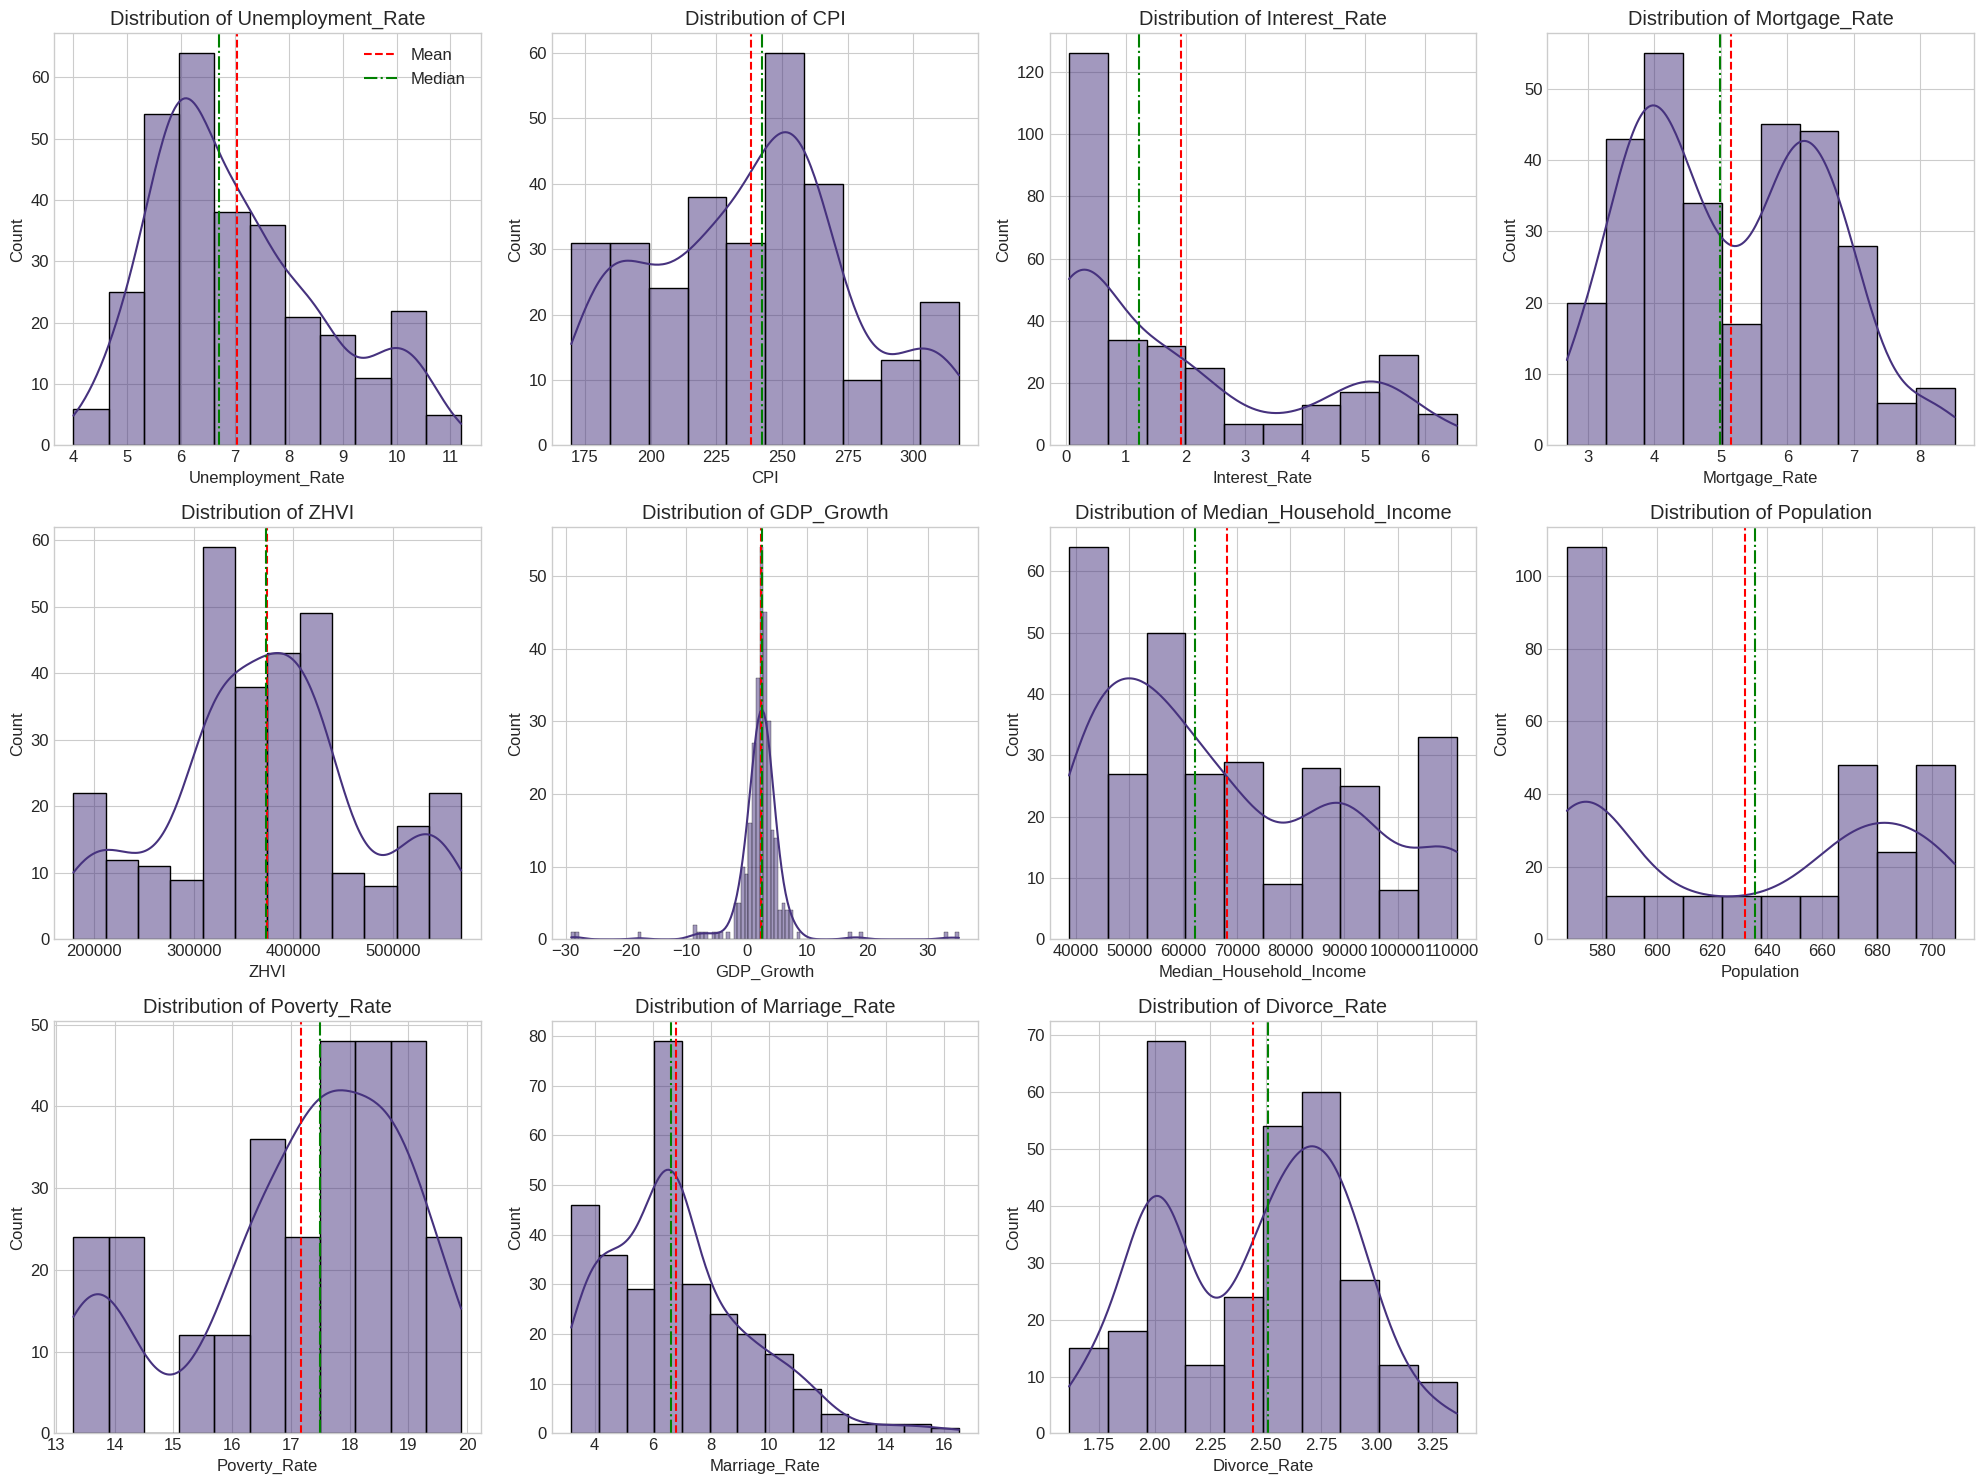

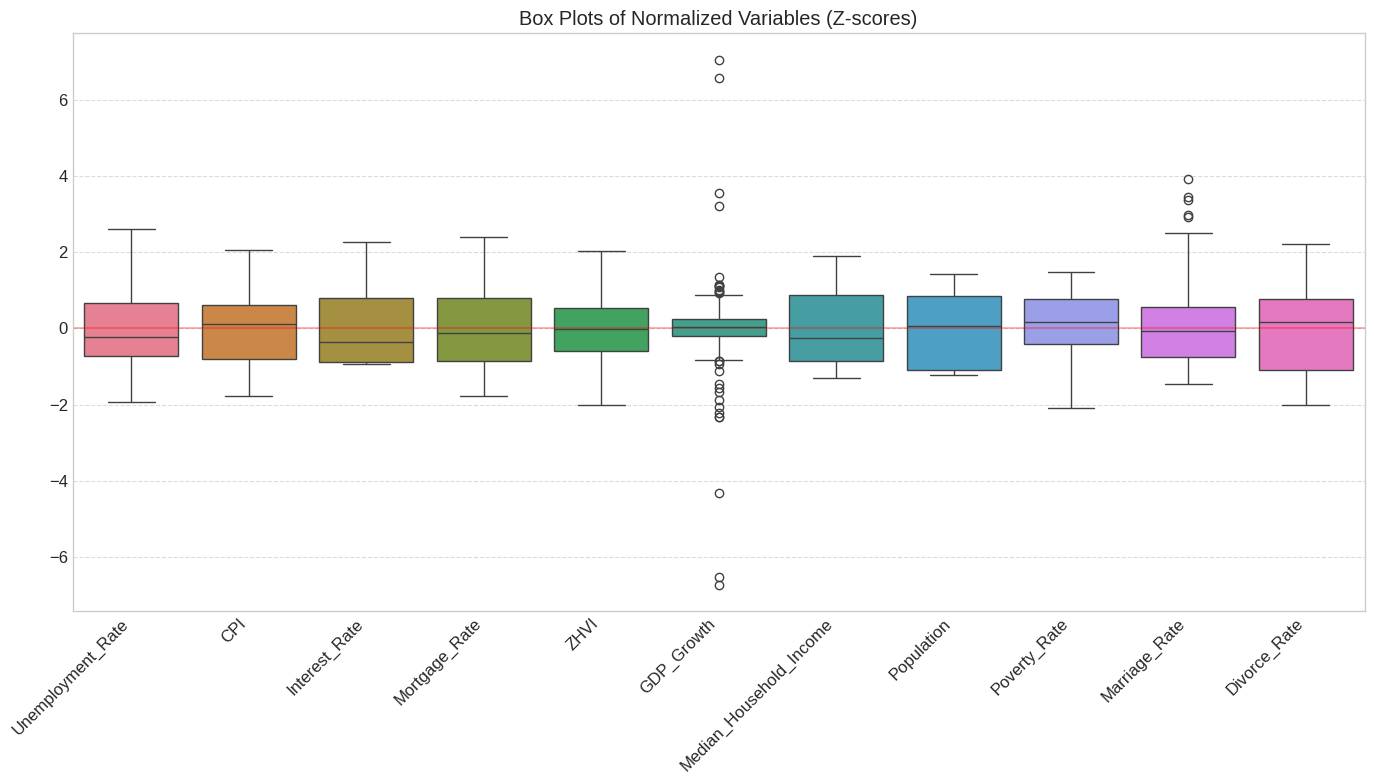


=== Key Observations from Descriptive Statistics ===

1. Central Tendencies:
  - Unemployment_Rate: Mean = 7.04, Median = 6.70, Skewness = 0.65 (right skew)
  - CPI: Mean = 238.06, Median = 242.39, Skewness = 0.13 (minimal skew)
  - Interest_Rate: Mean = 1.92, Median = 1.21, Skewness = 0.84 (right skew)
  - Mortgage_Rate: Mean = 5.15, Median = 4.99, Skewness = 0.21 (minimal skew)
  - ZHVI: Mean = 373171.07, Median = 372792.13, Skewness = 0.02 (minimal skew)
  - GDP_Growth: Mean = 2.30, Median = 2.47, Skewness = -0.01 (minimal skew)
  - Median_Household_Income: Mean = 68180.48, Median = 62284.26, Skewness = 0.55 (right skew)
  - Population: Mean = 631.91, Median = 635.74, Skewness = 0.02 (minimal skew)
  - Poverty_Rate: Mean = 17.17, Median = 17.50, Skewness = -0.72 (left skew)
  - Marriage_Rate: Mean = 6.82, Median = 6.64, Skewness = 0.91 (right skew)
  - Divorce_Rate: Mean = 2.44, Median = 2.51, Skewness = -0.12 (minimal skew)

2. Variability:
  - Unemployment_Rate: Coefficient of Va

In [3]:
# Generate comprehensive descriptive statistics
desc_stats = df.describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90]).T

# Add additional statistics
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['coef_var'] = desc_stats['std'] / desc_stats['mean'] * 100  # Coefficient of variation
desc_stats['skewness'] = df.skew()
desc_stats['kurtosis'] = df.kurtosis()

# Display the enhanced statistics
print("Enhanced Descriptive Statistics:")
desc_stats = desc_stats[['count', 'mean', 'std', 'min', '10%', '25%', '50%', '75%', '90%', 'max', 'range', 'coef_var', 'skewness', 'kurtosis']]
display(desc_stats)

# Create visualizations of distributions
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs = axs.flatten()

for i, col in enumerate(df.drop(['Year', 'Month'], axis=1).columns):
    if i < len(axs):
        # Create a density plot with histogram
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'Distribution of {col}')
        
        # Add mean and median lines
        axs[i].axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
        axs[i].axvline(df[col].median(), color='green', linestyle='-.', label='Median')
        
        # Add labels
        if i == 0:  # Only add legend to the first plot
            axs[i].legend()
            
        # Format x-axis to avoid scientific notation
        axs[i].ticklabel_format(axis='x', style='plain')
        
# Hide any unused subplots
for j in range(i+1, len(axs)):
    axs[j].set_visible(False)
    
plt.tight_layout()
plt.savefig('outputs/EDA/variable_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Create box plots to visualize the distribution and identify outliers
plt.figure(figsize=(14, 8))
columns_to_plot = [col for col in df.columns if col not in ['Year', 'Month']]

# Normalize data for better visual comparison
df_normalized = (df[columns_to_plot] - df[columns_to_plot].mean()) / df[columns_to_plot].std()
sns.boxplot(data=df_normalized)
plt.title('Box Plots of Normalized Variables (Z-scores)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Add mean reference line
plt.tight_layout()
plt.savefig('outputs/EDA/normalized_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary of key observations from descriptive statistics
print("\n=== Key Observations from Descriptive Statistics ===")
print("\n1. Central Tendencies:")
for col in columns_to_plot:
    mean_val = df[col].mean()
    median_val = df[col].median()
    skew = df[col].skew()
    skew_direction = "right" if skew > 0.5 else "left" if skew < -0.5 else "minimal"
    print(f"  - {col}: Mean = {mean_val:.2f}, Median = {median_val:.2f}, Skewness = {skew:.2f} ({skew_direction} skew)")

print("\n2. Variability:")
for col in columns_to_plot:
    cv = (df[col].std() / df[col].mean()) * 100
    variability = "high" if cv > 30 else "moderate" if cv > 15 else "low"
    print(f"  - {col}: Coefficient of Variation = {cv:.2f}% ({variability} variability)")

## 3. Trend Analysis

Let's examine how each variable has evolved over time. This will help us identify key trends, cycles, and anomalies in the data, particularly in relation to the housing market.

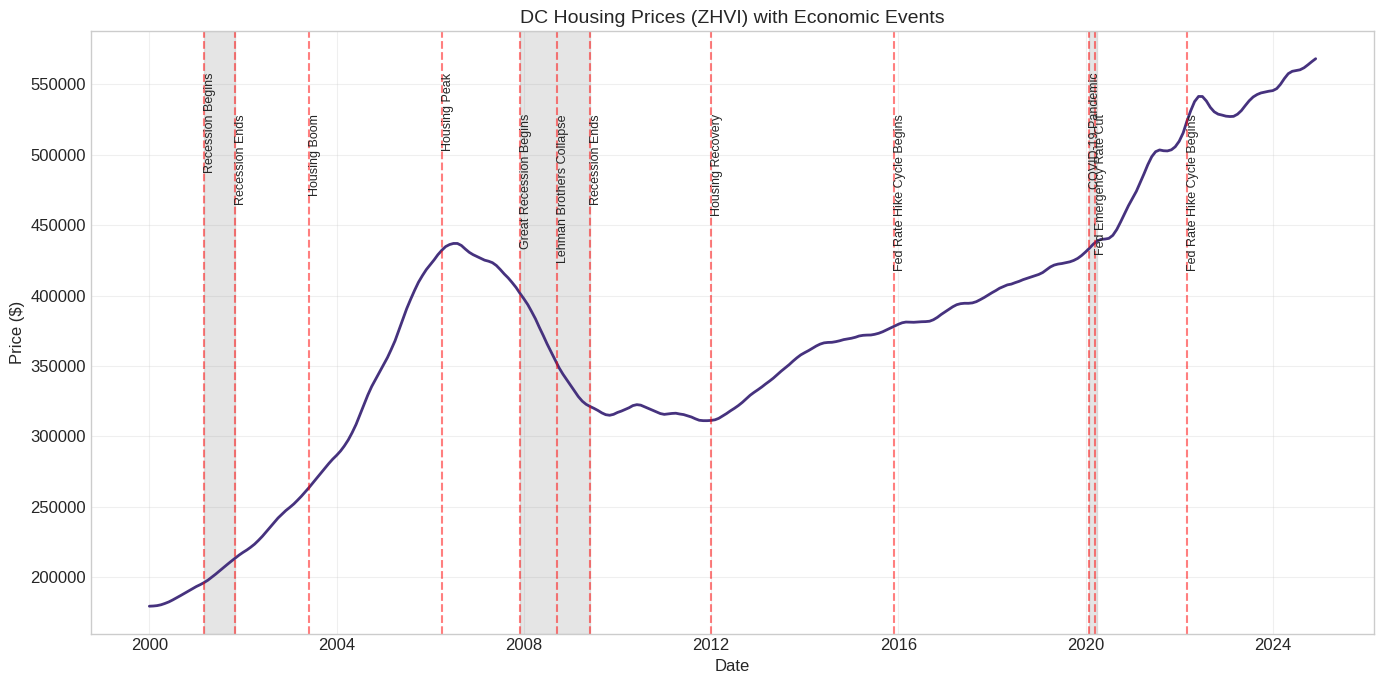

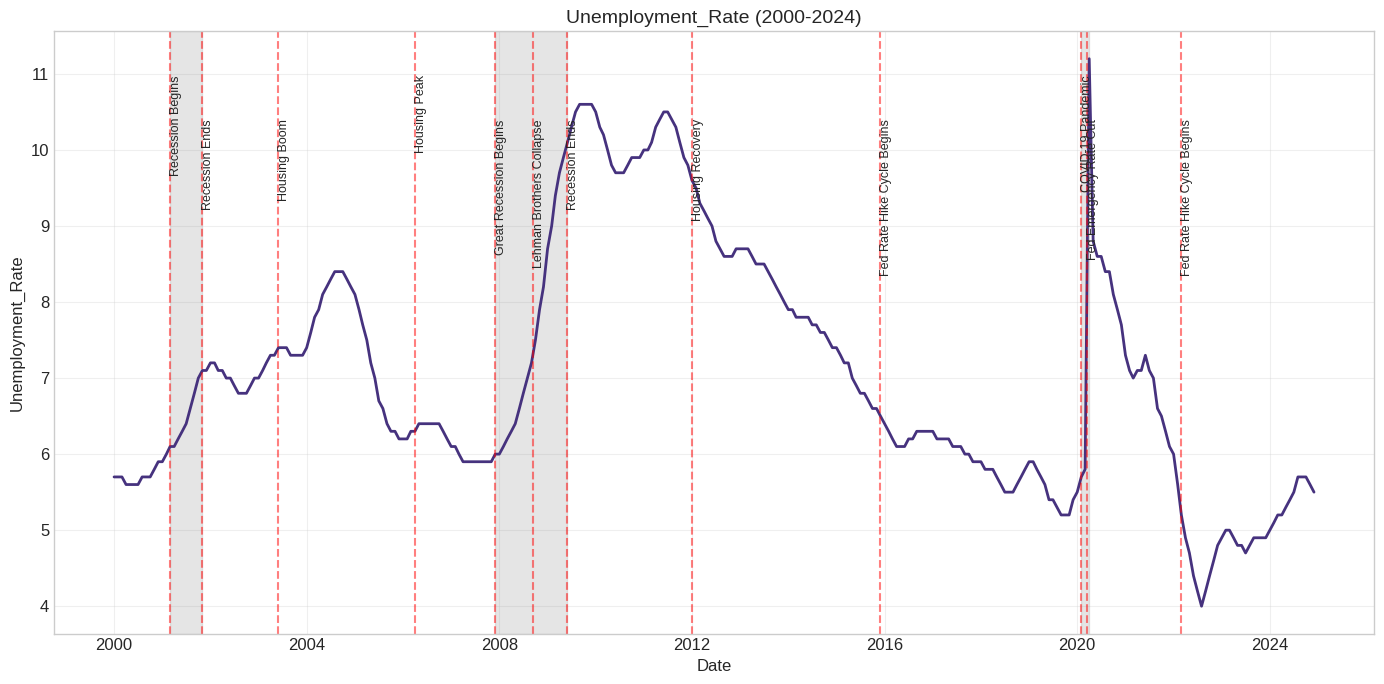

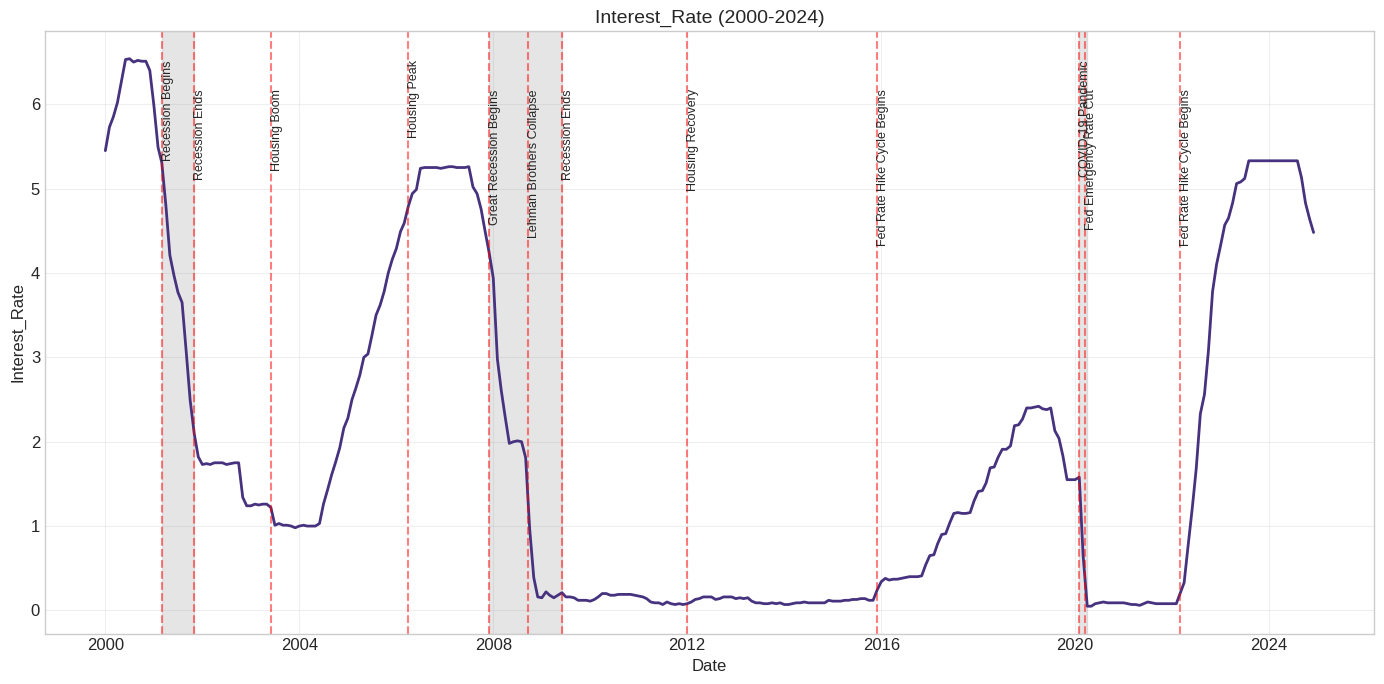

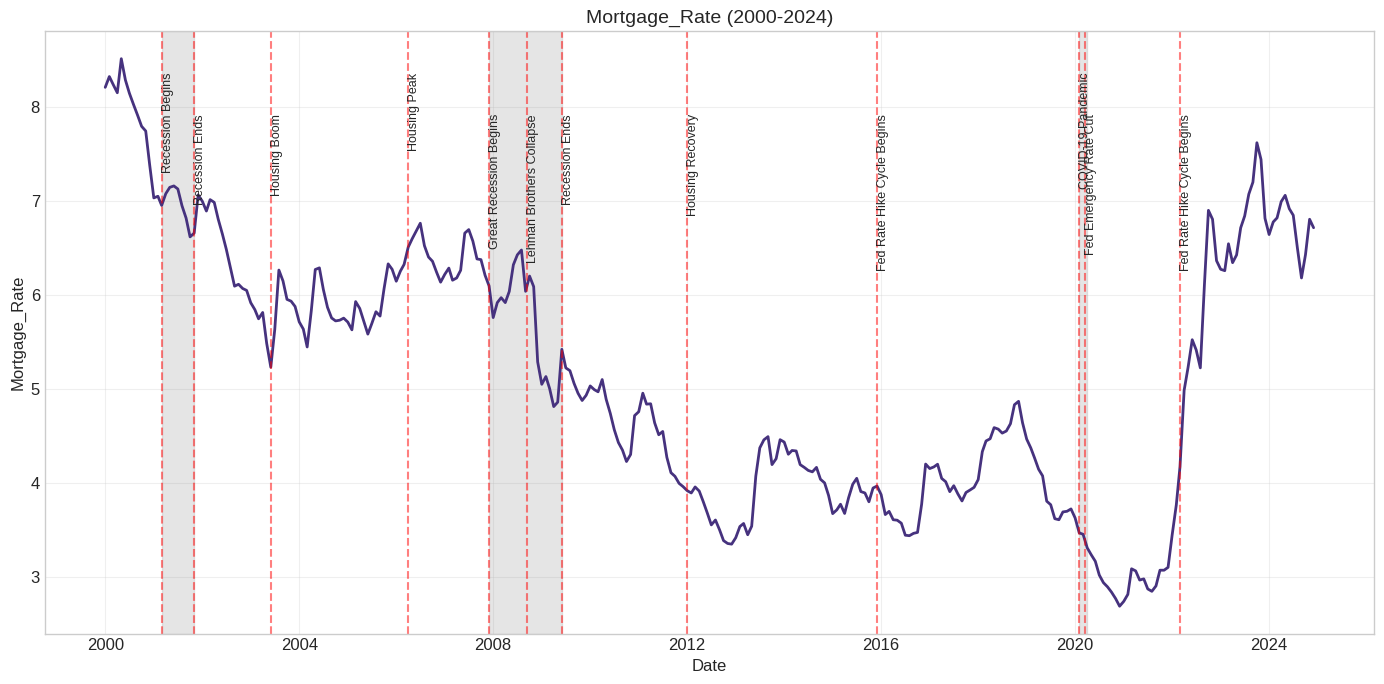

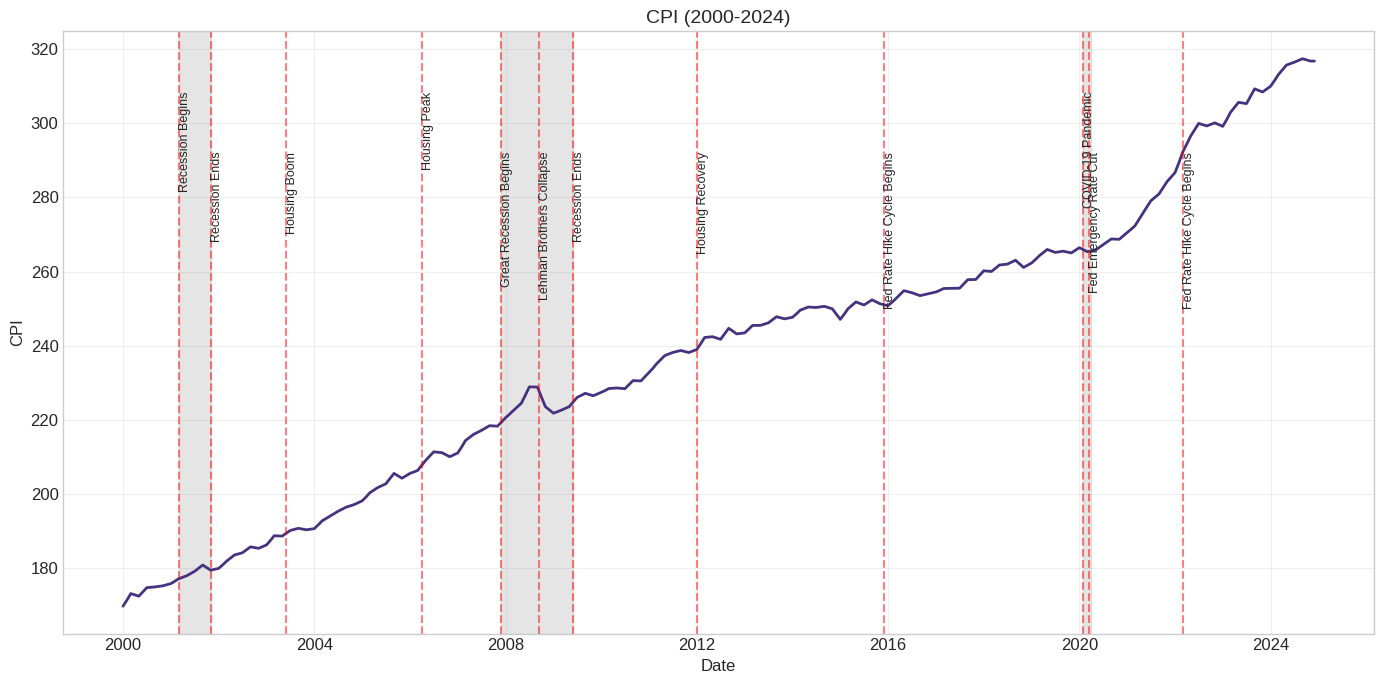

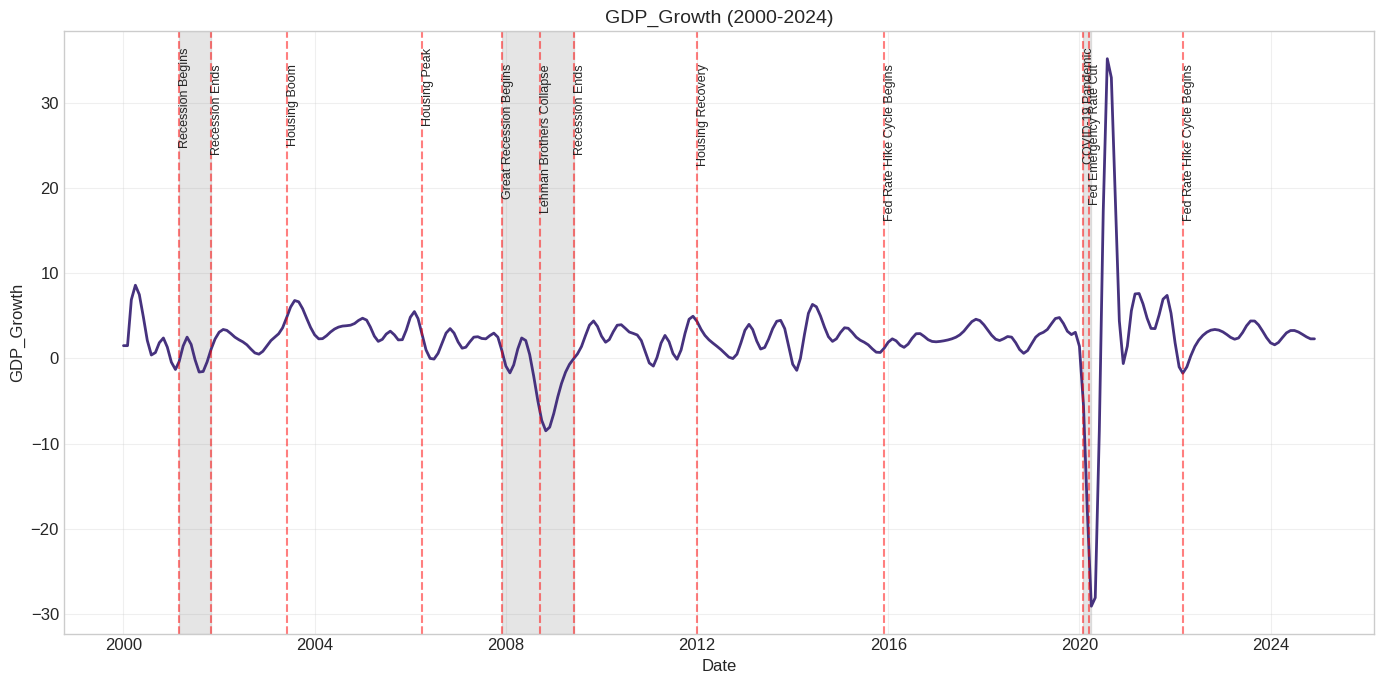

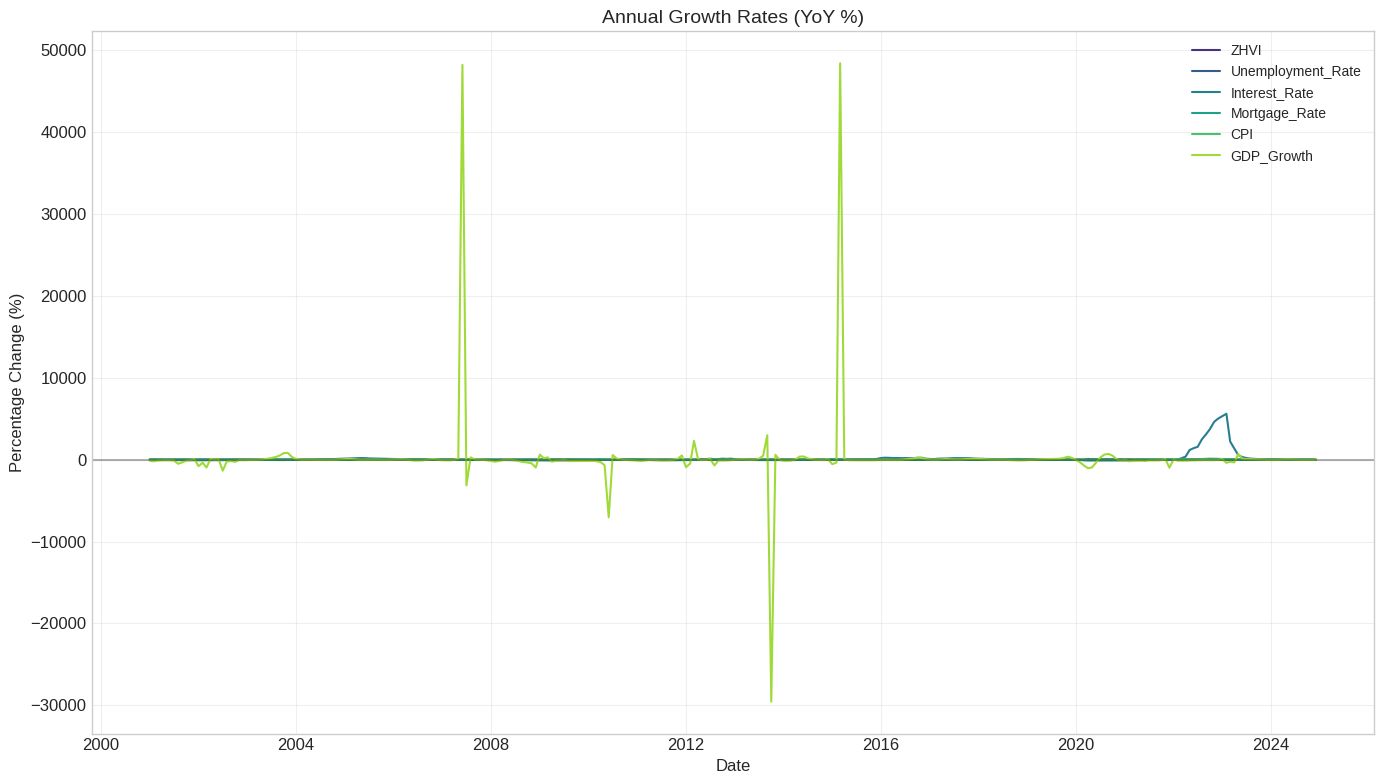

,Period,Start,End,Duration (Years),Total Change (%),Annualized Change (%),Avg. Interest Rate (%),Avg. Mortgage Rate (%),Avg. Unemployment (%)
0,Housing Boom,Jan 2000,Apr 2006,6.25,141.15,15.13,3.00,6.50,6.88
1,Housing Bust,May 2006,May 2009,3.00,-25.78,-9.46,3.40,6.08,6.79
2,Post-Crisis Stabilization,Jun 2009,Jan 2012,2.58,-3.09,-1.21,0.14,4.67,10.14
3,Recovery & Growth,Feb 2012,Dec 2019,7.83,37.45,4.15,0.74,3.97,6.92
4,Pandemic Boom,Jan 2020,Dec 2021,1.92,17.35,8.71,0.23,3.03,7.38
5,Rate Hike Era,Jan 2022,Jan 2024,2.00,7.06,3.47,3.43,6.08,4.82


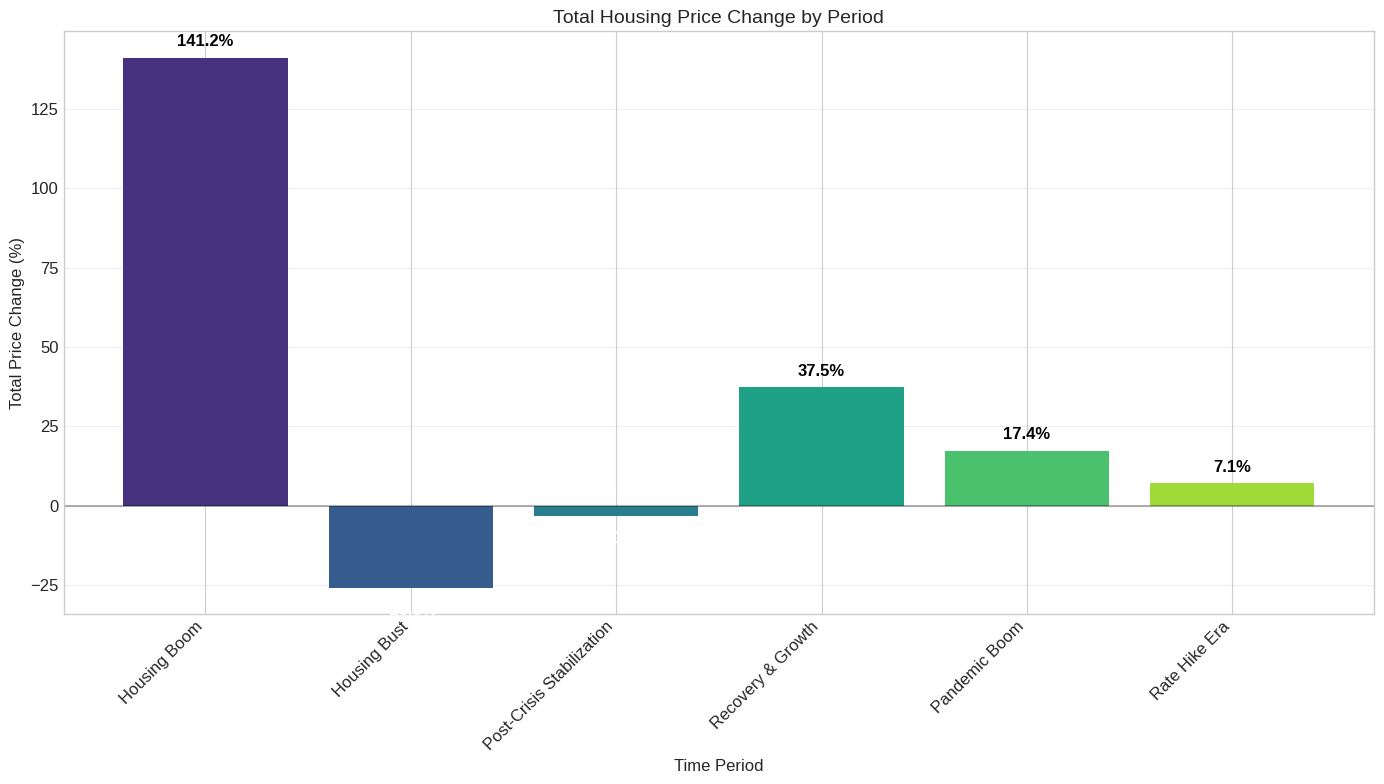

In [4]:
# Define important economic events for reference
economic_events = {
    '2001-03-01': 'Recession Begins',
    '2001-11-01': 'Recession Ends',
    '2003-06-01': 'Housing Boom',
    '2006-04-01': 'Housing Peak',
    '2007-12-01': 'Great Recession Begins',
    '2008-09-15': 'Lehman Brothers Collapse',
    '2009-06-01': 'Recession Ends',
    '2012-01-01': 'Housing Recovery',
    '2015-12-01': 'Fed Rate Hike Cycle Begins',
    '2020-02-01': 'COVID-19 Pandemic',
    '2020-03-15': 'Fed Emergency Rate Cut',
    '2022-03-01': 'Fed Rate Hike Cycle Begins'
}

# Function to plot time series with economic events
def plot_time_series(df, column, title=None, ylabel=None, show_events=True, label_events=True):
    """Plot a time series with economic events highlighted"""
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot the time series
    ax.plot(df.index, df[column], linewidth=2)
    
    # Add recession periods as shaded areas
    recessions = [
        ('2001-03-01', '2001-11-01'),  # Dot-com bubble
        ('2007-12-01', '2009-06-01'),  # Great Recession
        ('2020-02-01', '2020-04-01')   # COVID-19 Recession
    ]
    
    if show_events:
        for start, end in recessions:
            ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.2, color='gray')
        
        # Add vertical lines for key events
        for date, event in economic_events.items():
            date_obj = pd.to_datetime(date)
            if date_obj >= df.index.min() and date_obj <= df.index.max():
                ax.axvline(date_obj, color='r', linestyle='--', alpha=0.5)
                
                # Add labels if requested
                if label_events:
                    y_pos = 0.95 if event in ['Recession Begins', 'Housing Peak', 'COVID-19 Pandemic'] else 0.9
                    ax.text(date_obj, ax.get_ylim()[1] * y_pos, event, rotation=90, 
                            verticalalignment='top', fontsize=9)
    
    # Set title and labels
    ax.set_title(title or f"{column} (2000-2024)", fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(ylabel or column, fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Format y-axis to avoid scientific notation
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'outputs/EDA/{column.lower()}_trend.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig, ax

# Plot ZHVI (Housing Prices) with economic events
plot_time_series(df, 'ZHVI', 'DC Housing Prices (ZHVI) with Economic Events', 'Price ($)')

# Plot key economic indicators
economic_indicators = ['Unemployment_Rate', 'Interest_Rate', 'Mortgage_Rate', 'CPI', 'GDP_Growth']
for indicator in economic_indicators:
    plot_time_series(df, indicator)

# Calculate and plot annual growth rates
df_pct_change = df.copy()
for col in df.columns:
    if col not in ['Year', 'Month']:
        df_pct_change[f'{col}_YoY_pct'] = df[col].pct_change(periods=12) * 100

# Plot annual growth rates for housing prices and key indicators
plt.figure(figsize=(14, 8))
for indicator in ['ZHVI_YoY_pct'] + [f'{ind}_YoY_pct' for ind in economic_indicators]:
    if indicator in df_pct_change.columns:
        plt.plot(df_pct_change.index, df_pct_change[indicator], label=indicator.replace('_YoY_pct', ''))

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Annual Growth Rates (YoY %)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage Change (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/EDA/annual_growth_rates.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify key trend periods for housing prices
trend_periods = [
    ('2000-01-01', '2006-04-01', 'Housing Boom'),
    ('2006-05-01', '2009-05-01', 'Housing Bust'),
    ('2009-06-01', '2012-01-01', 'Post-Crisis Stabilization'),
    ('2012-02-01', '2019-12-01', 'Recovery & Growth'),
    ('2020-01-01', '2021-12-01', 'Pandemic Boom'),
    ('2022-01-01', '2024-01-01', 'Rate Hike Era')
]

# Calculate statistics for each period
period_stats = []
for start, end, name in trend_periods:
    period_df = df.loc[start:end]
    
    # Calculate total change and average annual change
    start_zhvi = period_df['ZHVI'].iloc[0]
    end_zhvi = period_df['ZHVI'].iloc[-1]
    total_chg = (end_zhvi - start_zhvi) / start_zhvi * 100
    
    # Calculate duration in years
    duration_years = (pd.to_datetime(end) - pd.to_datetime(start)).days / 365.25
    annual_chg = (((end_zhvi / start_zhvi) ** (1/duration_years)) - 1) * 100
    
    period_stats.append({
        'Period': name,
        'Start': pd.to_datetime(start).strftime('%b %Y'),
        'End': pd.to_datetime(end).strftime('%b %Y'),
        'Duration (Years)': duration_years,
        'Start ZHVI': start_zhvi,
        'End ZHVI': end_zhvi,
        'Total Change (%)': total_chg,
        'Annualized Change (%)': annual_chg,
        'Avg. Interest Rate (%)': period_df['Interest_Rate'].mean(),
        'Avg. Mortgage Rate (%)': period_df['Mortgage_Rate'].mean(),
        'Avg. Unemployment (%)': period_df['Unemployment_Rate'].mean()
    })

# Convert to DataFrame for display
period_stats_df = pd.DataFrame(period_stats)
display(period_stats_df[['Period', 'Start', 'End', 'Duration (Years)', 'Total Change (%)', 'Annualized Change (%)', 
                          'Avg. Interest Rate (%)', 'Avg. Mortgage Rate (%)', 'Avg. Unemployment (%)']])

# Create a visualization of housing price changes by period
plt.figure(figsize=(14, 8))
plt.bar(period_stats_df['Period'], period_stats_df['Total Change (%)'], color=sns.color_palette("viridis", len(period_stats_df)))
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Total Housing Price Change by Period', fontsize=14)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Total Price Change (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add data labels
for i, value in enumerate(period_stats_df['Total Change (%)']):
    plt.text(i, value + (5 if value >= 0 else -5), f'{value:.1f}%', 
             ha='center', va='center' if value >= 0 else 'top', 
             fontweight='bold', color='black' if value >= 0 else 'white')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/EDA/zhvi_change_by_period.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Correlation Analysis

We'll analyze the relationships between different variables to understand how they interact and which factors have the strongest relationship with housing prices.

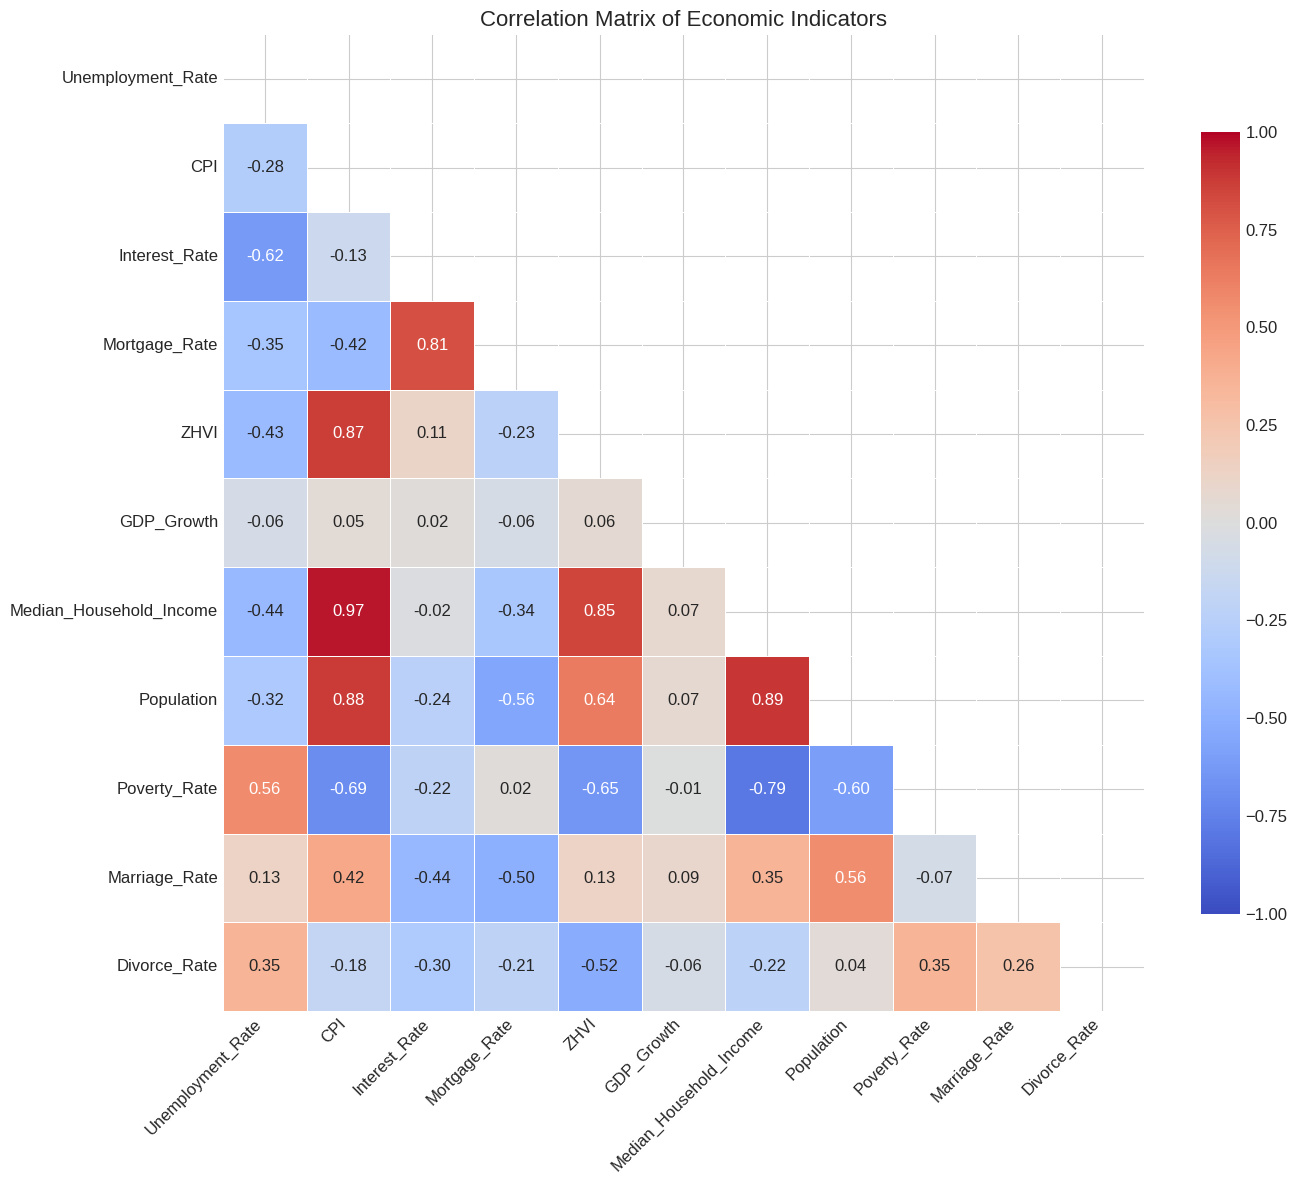

/tmp/ipykernel_11677/1398254844.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=zhvi_corr.values, y=zhvi_corr.index, palette=colors, orient='h')


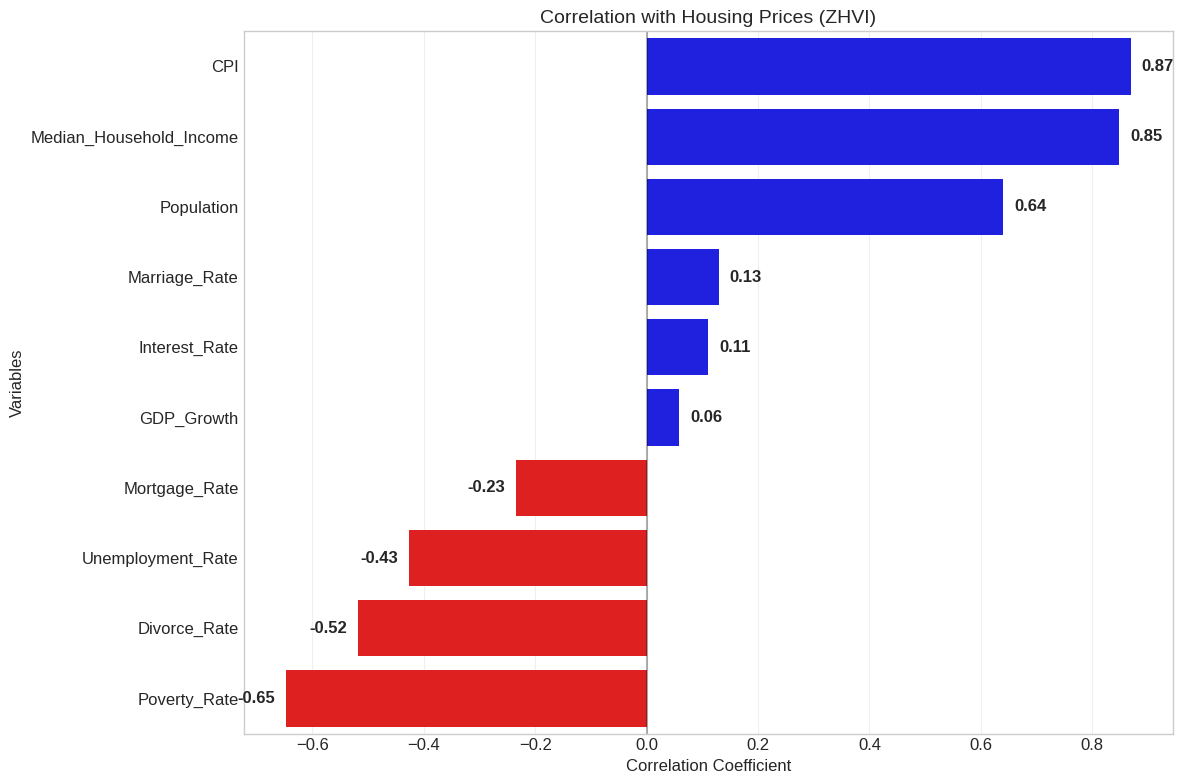

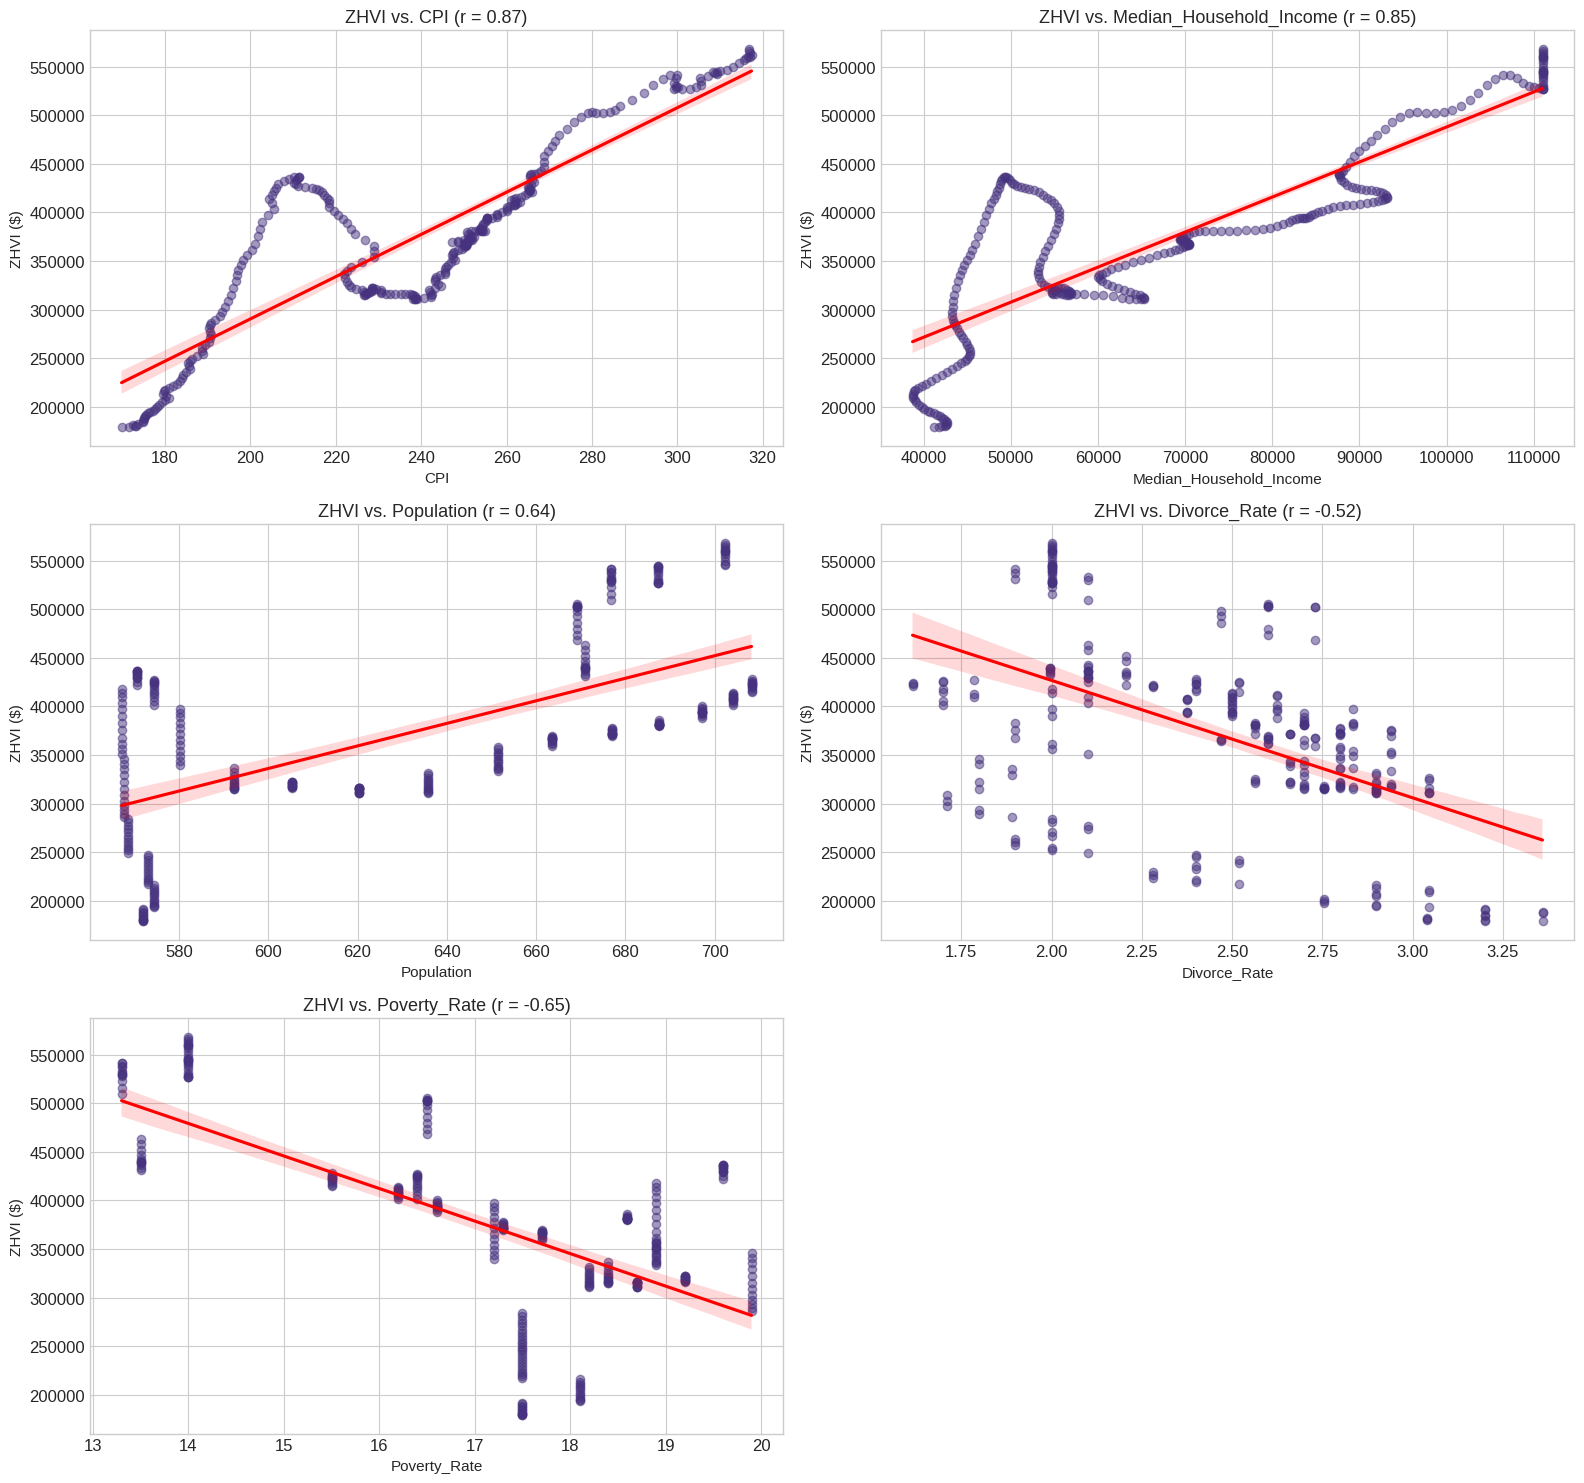

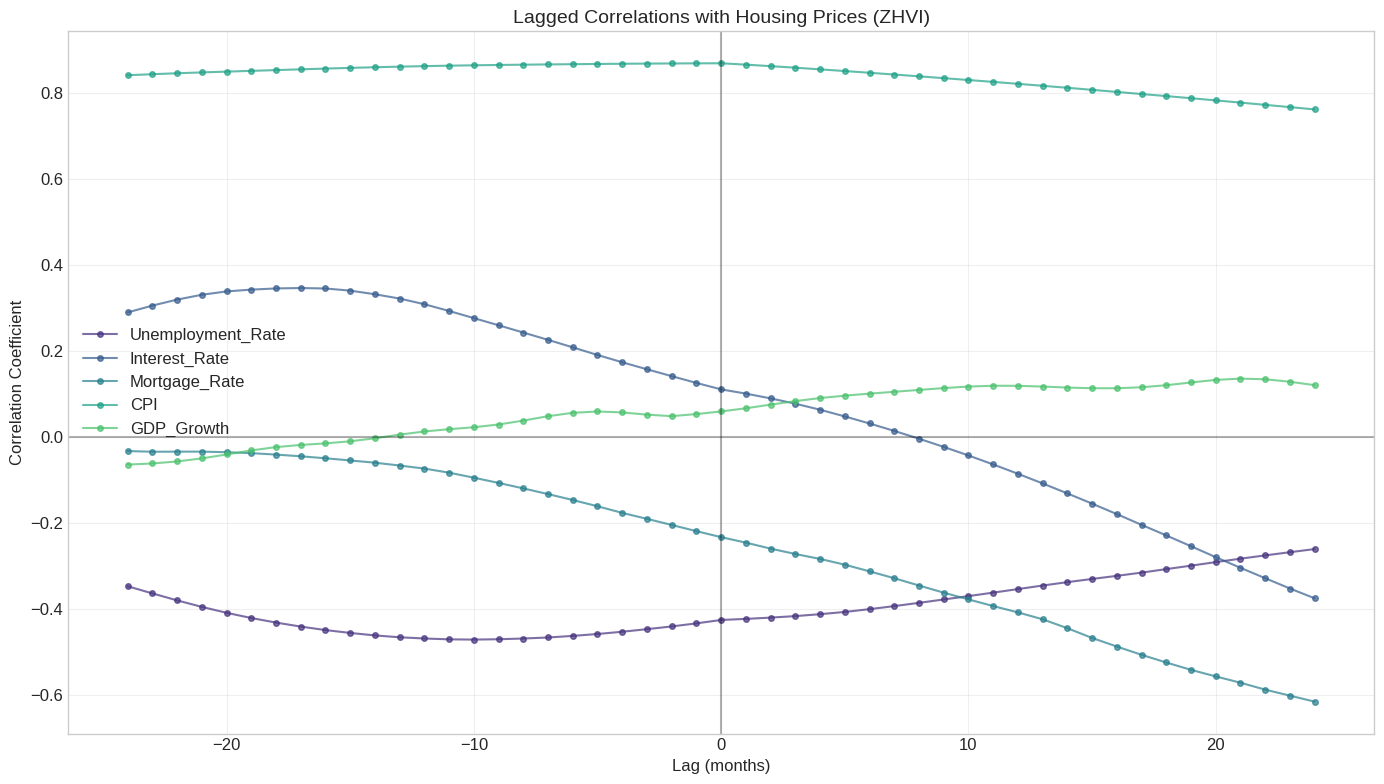

Optimal Lags with Housing Prices (ZHVI):
Unemployment_Rate leads ZHVI by 10 months (r = -0.47)
Interest_Rate lags ZHVI by 24 months (r = -0.38)
Mortgage_Rate lags ZHVI by 24 months (r = -0.62)
CPI coincident with ZHVI by 0 months (r = 0.87)
GDP_Growth lags ZHVI by 21 months (r = 0.14)


In [5]:
# Calculate correlation matrix
correlation_vars = [col for col in df.columns if col not in ['Year', 'Month']]
corr_matrix = df[correlation_vars].corr()

# Create correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create mask for upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f',
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Economic Indicators', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('outputs/EDA/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Focus on correlations with ZHVI (housing prices)
zhvi_corr = corr_matrix['ZHVI'].drop('ZHVI').sort_values(ascending=False)

# Create bar chart of correlations with housing prices
plt.figure(figsize=(12, 8))
colors = ['blue' if x > 0 else 'red' for x in zhvi_corr.values]
sns.barplot(x=zhvi_corr.values, y=zhvi_corr.index, palette=colors, orient='h')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Correlation with Housing Prices (ZHVI)', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Add correlation values to bars
for i, v in enumerate(zhvi_corr.values):
    plt.text(v + (0.02 if v >= 0 else -0.02), i, f'{v:.2f}', 
             va='center', ha='left' if v >= 0 else 'right', fontweight='bold')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/EDA/zhvi_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# Create scatter plots for strongly correlated variables with ZHVI
strong_correlations = zhvi_corr[abs(zhvi_corr) >= 0.5]

if len(strong_correlations) > 0:
    n_rows = (len(strong_correlations) + 1) // 2  # Ceiling division for 2 columns
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 and len(strong_correlations) == 1 else axes
    
    for i, (var, corr) in enumerate(strong_correlations.items()):
        ax = axes[i]
        sns.regplot(x=df[var], y=df['ZHVI'], ax=ax, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
        ax.set_title(f'ZHVI vs. {var} (r = {corr:.2f})', fontsize=13)
        ax.set_xlabel(var, fontsize=11)
        ax.set_ylabel('ZHVI ($)', fontsize=11)
        ax.ticklabel_format(style='plain', axis='both')
        
    # Hide any unused subplots
    if n_rows > 1 or (n_rows == 1 and len(strong_correlations) < 2):
        for j in range(len(strong_correlations), len(axes)):
            if j < len(axes):
                axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('outputs/EDA/zhvi_scatter_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No variables found with correlation coefficient above 0.5")

# Lagged correlation analysis
# This assesses how variables at different time lags correlate with housing prices
max_lag = 24  # Maximum lag in months to consider
lag_variables = ['Unemployment_Rate', 'Interest_Rate', 'Mortgage_Rate', 'CPI', 'GDP_Growth']
lag_corrs = pd.DataFrame(index=range(-max_lag, max_lag + 1))

for var in lag_variables:
    corrs = []
    
    # Negative lags (variable leads ZHVI)
    for lag in range(-max_lag, 0):
        # Shift ZHVI forward (into the future)
        corr = df[var].corr(df['ZHVI'].shift(abs(lag)))
        corrs.append(corr)
    
    # Zero lag (contemporaneous)
    corrs.append(df[var].corr(df['ZHVI']))
    
    # Positive lags (variable lags ZHVI)
    for lag in range(1, max_lag + 1):
        # Shift the variable forward (into the future)
        corr = df[var].shift(lag).corr(df['ZHVI'])
        corrs.append(corr)
    
    lag_corrs[var] = corrs

# Plot lagged correlations
plt.figure(figsize=(14, 8))
for var in lag_variables:
    plt.plot(lag_corrs.index, lag_corrs[var], marker='o', markersize=4, label=var, alpha=0.7)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Lagged Correlations with Housing Prices (ZHVI)', fontsize=14)
plt.xlabel('Lag (months)', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('outputs/EDA/lagged_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# Find the lag with the strongest correlation for each variable
optimal_lags = {}
for var in lag_variables:
    max_corr_idx = lag_corrs[var].abs().idxmax()
    max_corr = lag_corrs.loc[max_corr_idx, var]
    optimal_lags[var] = {'lag': max_corr_idx, 'correlation': max_corr}

# Display optimal lags
print("Optimal Lags with Housing Prices (ZHVI):")
for var, data in optimal_lags.items():
    lag = data['lag']
    corr = data['correlation']
    relationship = "leads" if lag < 0 else "coincident with" if lag == 0 else "lags"
    abs_lag = abs(lag)
    print(f"{var} {relationship} ZHVI by {abs_lag} month{'s' if abs_lag != 1 else ''} (r = {corr:.2f})")

## 5. Time Series Analysis

We'll analyze the time series properties of housing prices, including decomposition, seasonality, and stationarity. This is essential for understanding the temporal patterns and preparing for forecasting.

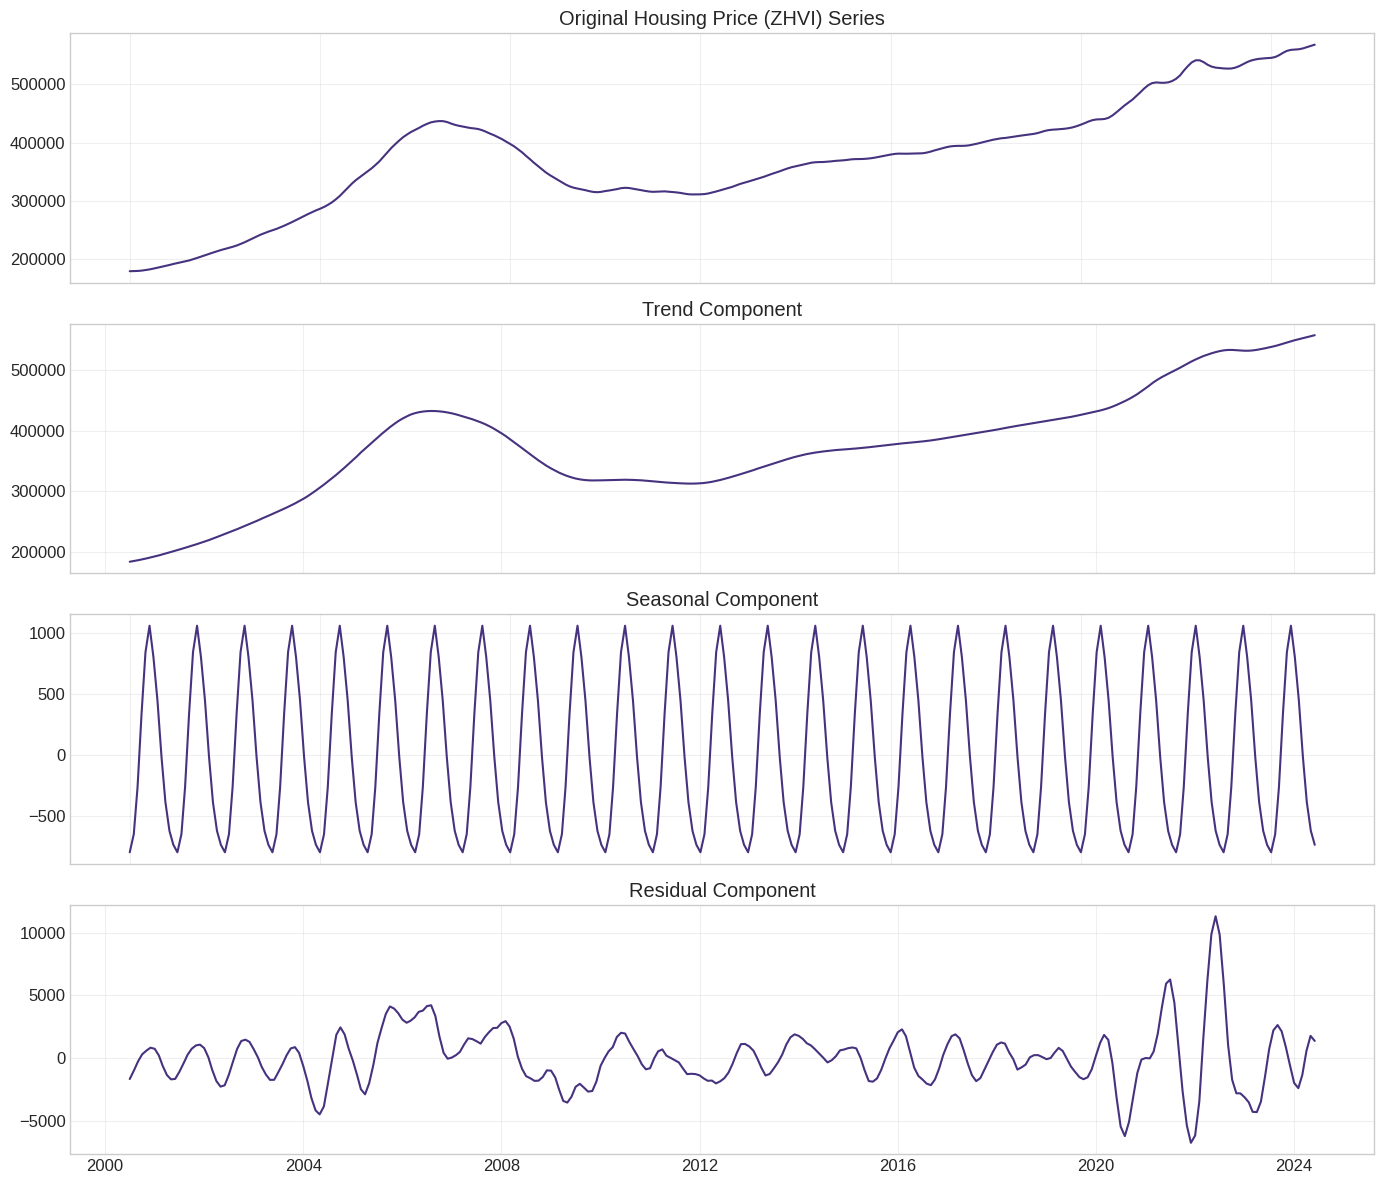

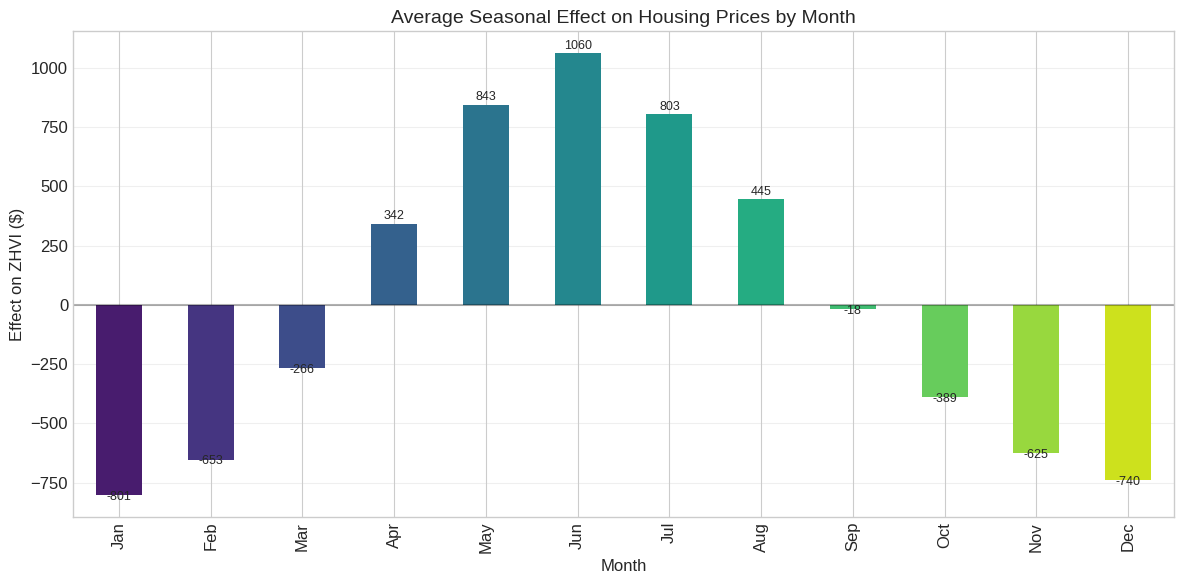

Augmented Dickey-Fuller Test Results:
ADF Statistic: -1.1775
p-value: 0.6832
Critical Values:
	1%: -3.4535
	5%: -2.8717
	10%: -2.5722
Result: Fail to reject the null hypothesis. The series is non-stationary.

KPSS Test Results:
KPSS Statistic: 1.9363
p-value: 0.0100
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Result: Reject the null hypothesis. The series is non-stationary.


/tmp/ipykernel_11677/2218131585.py:105: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


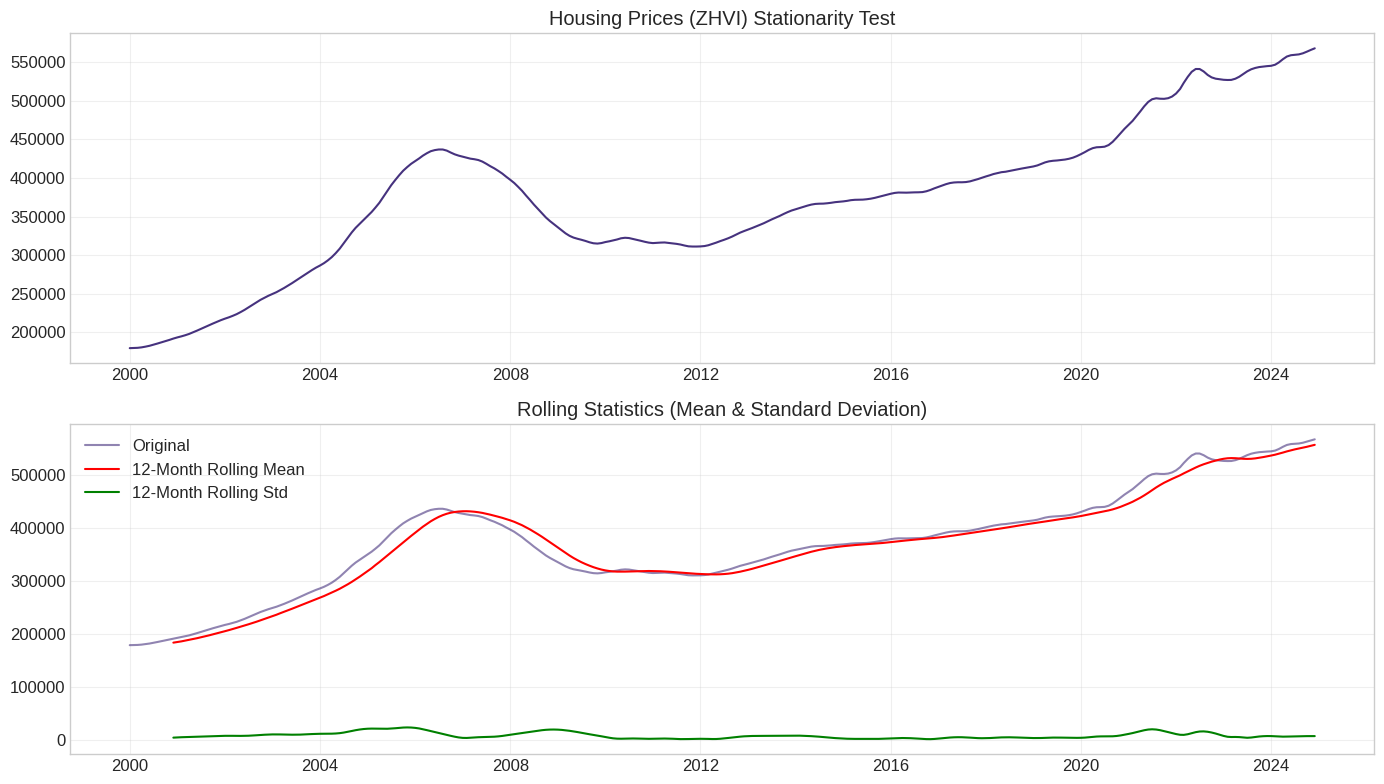

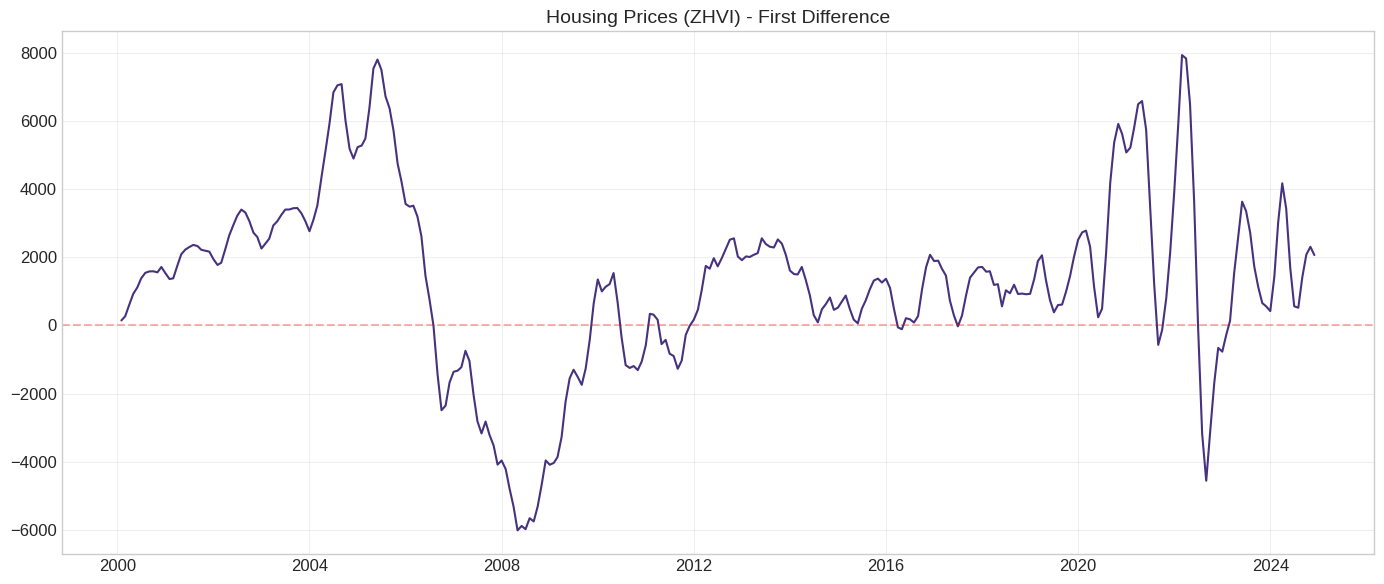

Augmented Dickey-Fuller Test Results:
ADF Statistic: -3.3416
p-value: 0.0131
Critical Values:
	1%: -3.4538
	5%: -2.8718
	10%: -2.5723
Result: Reject the null hypothesis. The series is stationary.

KPSS Test Results:
KPSS Statistic: 0.2087
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Result: Fail to reject the null hypothesis. The series is stationary.


/tmp/ipykernel_11677/2218131585.py:105: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


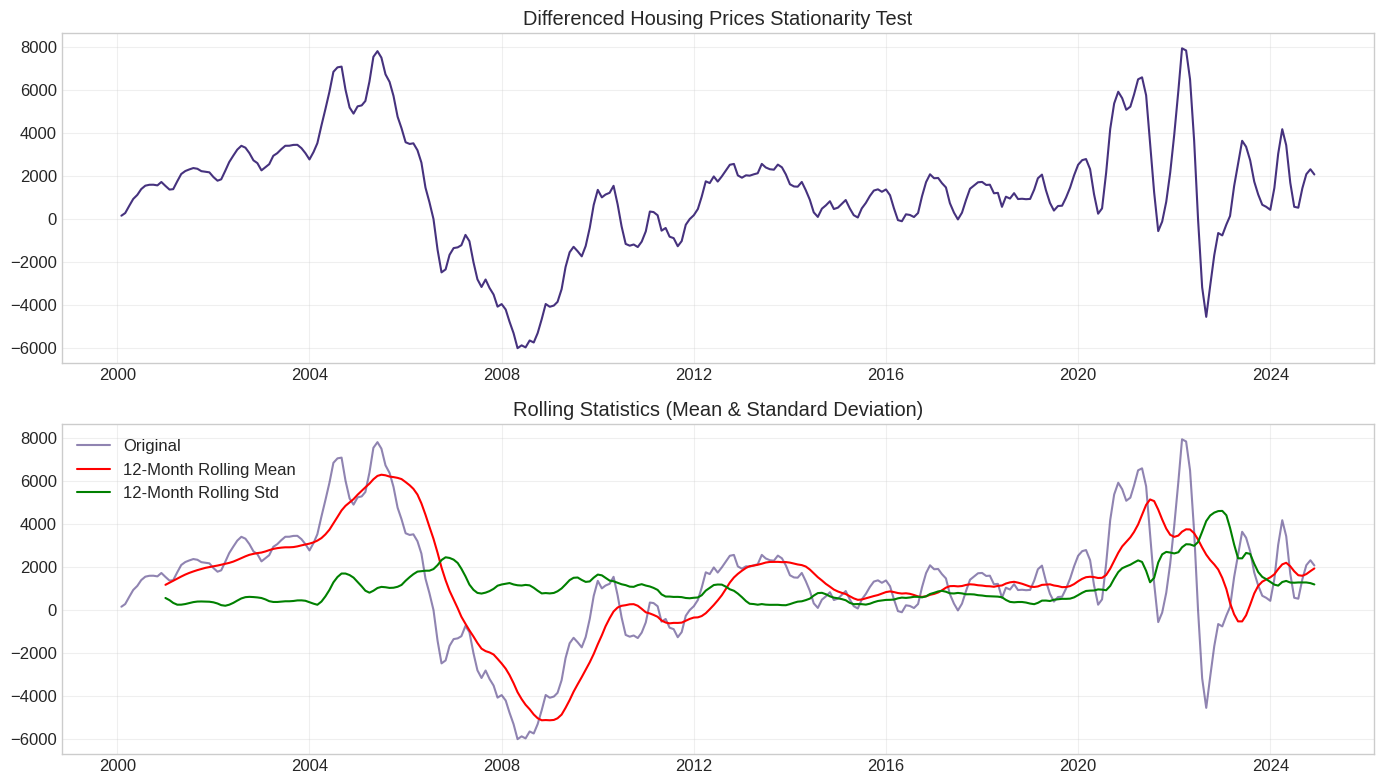

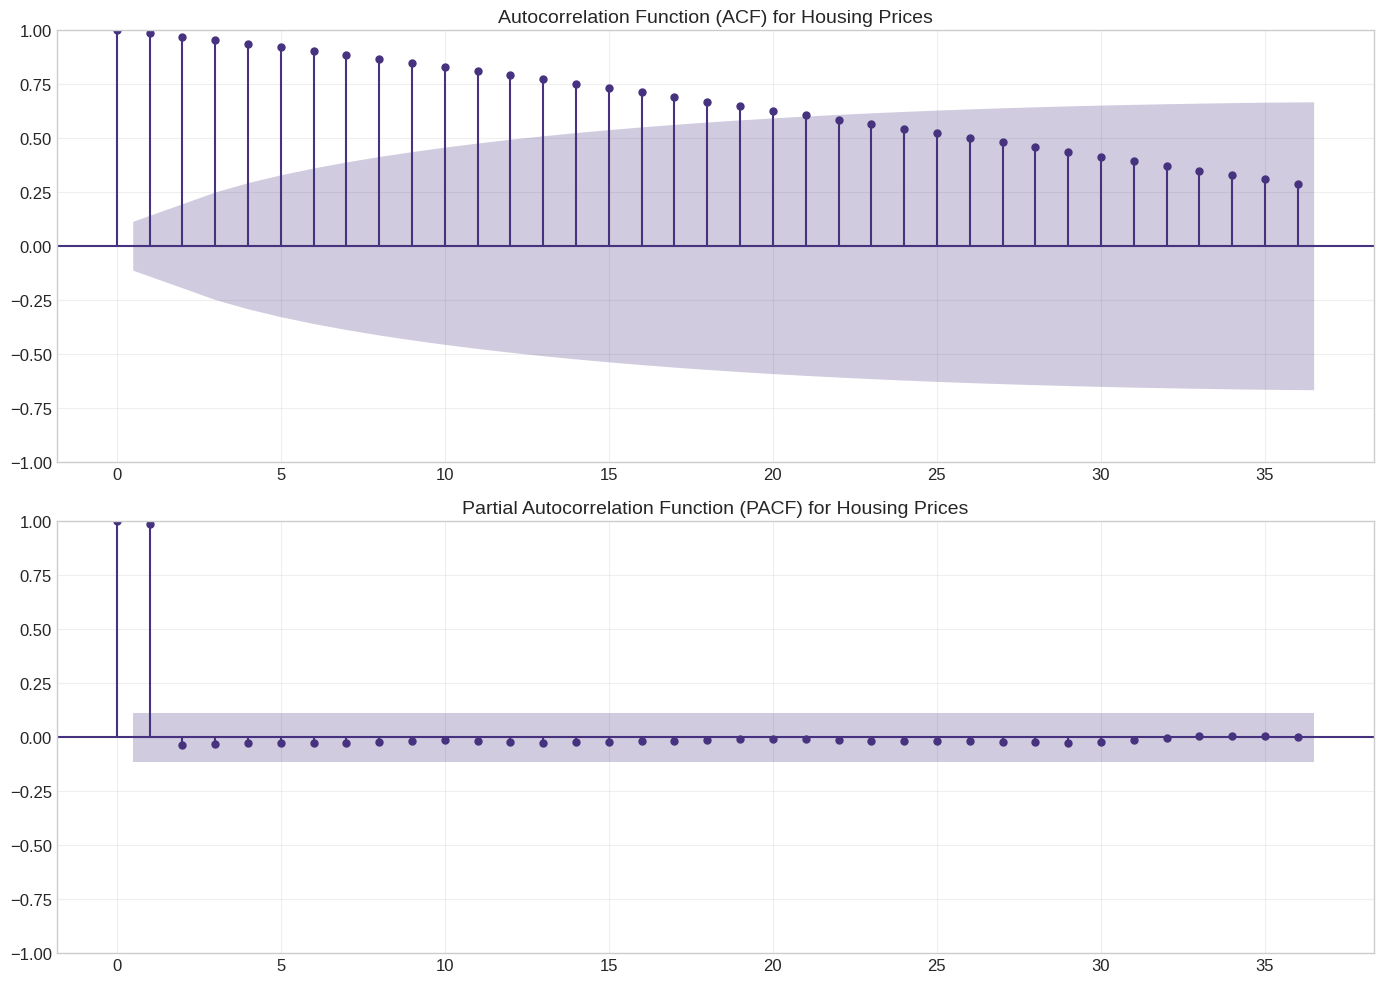

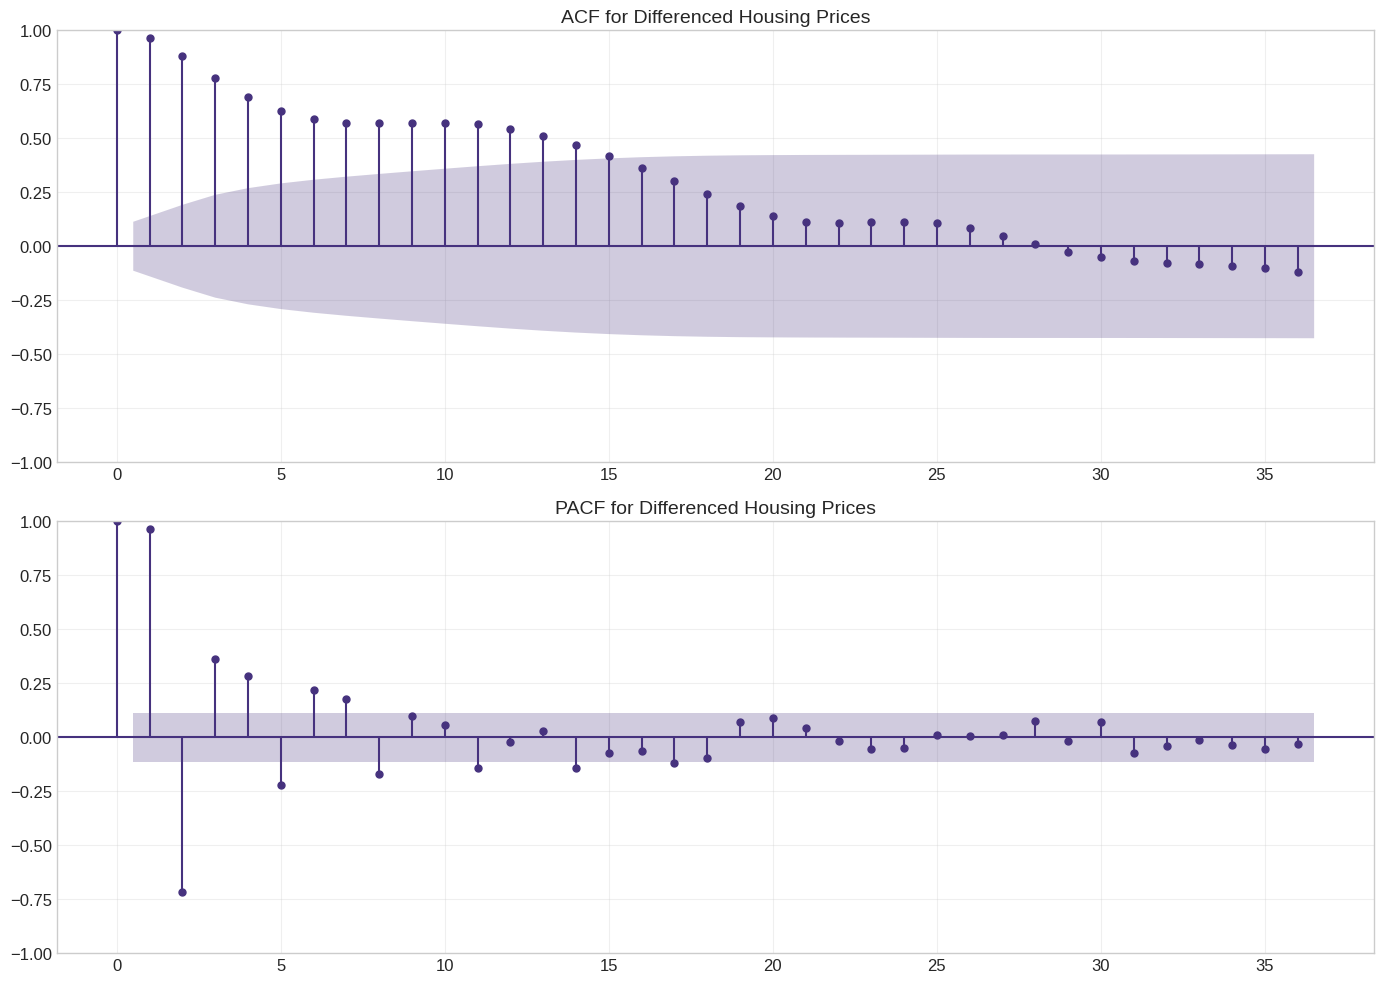

In [6]:
# Time series decomposition of housing prices (ZHVI)
# This decomposes the series into trend, seasonal, and residual components
decomposition = seasonal_decompose(df['ZHVI'], model='additive', period=12)  # 12 for monthly data

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))

# Original series
ax1.plot(decomposition.observed)
ax1.set_title('Original Housing Price (ZHVI) Series')
ax1.set_xticklabels([])
ax1.grid(True, alpha=0.3)

# Trend component
ax2.plot(decomposition.trend)
ax2.set_title('Trend Component')
ax2.set_xticklabels([])
ax2.grid(True, alpha=0.3)

# Seasonal component
ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal Component')
ax3.set_xticklabels([])
ax3.grid(True, alpha=0.3)

# Residual component
ax4.plot(decomposition.resid)
ax4.set_title('Residual Component')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/EDA/zhvi_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze monthly seasonality
seasonal_component = pd.DataFrame({'value': decomposition.seasonal})
seasonal_component['month'] = seasonal_component.index.month
avg_seasonal_effect = seasonal_component.groupby('month')['value'].mean()

# Plot monthly seasonality
plt.figure(figsize=(12, 6))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
avg_seasonal_effect.index = month_names
avg_seasonal_effect.plot(kind='bar', color=sns.color_palette("viridis", 12))
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Average Seasonal Effect on Housing Prices by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Effect on ZHVI ($)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(avg_seasonal_effect):
    plt.text(i, v + (20 if v >= 0 else -20), f'{v:.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/EDA/zhvi_seasonality.png', dpi=300, bbox_inches='tight')
plt.show()

# Stationarity Testing
# A stationary time series has constant mean, variance, and autocorrelation over time
def test_stationarity(series, title=None):
    """Test stationarity of a time series"""
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    
    # Plot the time series
    ax1.plot(series)
    ax1.set_title(title or 'Time Series')
    ax1.grid(True, alpha=0.3)
    
    # Plot rolling statistics
    rolling_mean = series.rolling(window=12).mean()
    rolling_std = series.rolling(window=12).std()
    
    ax2.plot(series, label='Original', alpha=0.6)
    ax2.plot(rolling_mean, label='12-Month Rolling Mean', color='red')
    ax2.plot(rolling_std, label='12-Month Rolling Std', color='green')
    ax2.set_title('Rolling Statistics (Mean & Standard Deviation)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    
    # Perform Augmented Dickey-Fuller test
    adf_result = adfuller(series.dropna())
    print(f"Augmented Dickey-Fuller Test Results:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.4f}")
    
    # Interpret the ADF test result
    # H0: Series has a unit root (non-stationary)
    # H1: Series does not have a unit root (stationary)
    if adf_result[1] <= 0.05:
        print("Result: Reject the null hypothesis. The series is stationary.")
        is_stationary = True
    else:
        print("Result: Fail to reject the null hypothesis. The series is non-stationary.")
        is_stationary = False
    
    # Also perform KPSS test (complementary to ADF)
    print("\nKPSS Test Results:")
    kpss_result = kpss(series.dropna(), regression='c')
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.4f}")
    
    # Interpret the KPSS test result
    # H0: Series is trend stationary
    # H1: Series has a unit root (non-stationary)
    if kpss_result[1] <= 0.05:
        print("Result: Reject the null hypothesis. The series is non-stationary.")
        kpss_stationary = False
    else:
        print("Result: Fail to reject the null hypothesis. The series is stationary.")
        kpss_stationary = True
    
    return fig, is_stationary, kpss_stationary

# Test stationarity of ZHVI (housing prices)
fig, adf_stationary, kpss_stationary = test_stationarity(df['ZHVI'], 'Housing Prices (ZHVI) Stationarity Test')
plt.savefig('outputs/EDA/zhvi_stationarity.png', dpi=300, bbox_inches='tight')
plt.show()

# If the series is non-stationary, create differenced series
if not adf_stationary:
    # First difference
    zhvi_diff = df['ZHVI'].diff().dropna()
    
    # Plot the differenced series
    plt.figure(figsize=(14, 6))
    plt.plot(zhvi_diff)
    plt.title('Housing Prices (ZHVI) - First Difference', fontsize=14)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('outputs/EDA/zhvi_first_difference.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test stationarity of differenced series
    fig, diff_adf_stationary, diff_kpss_stationary = test_stationarity(zhvi_diff, 'Differenced Housing Prices Stationarity Test')
    plt.savefig('outputs/EDA/zhvi_diff_stationarity.png', dpi=300, bbox_inches='tight')
    plt.show()

# Autocorrelation Analysis
# Plot ACF and PACF to assess autocorrelation and partial autocorrelation patterns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# ACF Plot
plot_acf(df['ZHVI'].dropna(), lags=36, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) for Housing Prices', fontsize=14)
ax1.grid(True, alpha=0.3)

# PACF Plot
plot_pacf(df['ZHVI'].dropna(), lags=36, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) for Housing Prices', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/EDA/zhvi_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

# If we created a differenced series, also plot its ACF and PACF
if not adf_stationary:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # ACF Plot for differenced series
    plot_acf(zhvi_diff.dropna(), lags=36, ax=ax1)
    ax1.set_title('ACF for Differenced Housing Prices', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # PACF Plot for differenced series
    plot_pacf(zhvi_diff.dropna(), lags=36, ax=ax2)
    ax2.set_title('PACF for Differenced Housing Prices', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('outputs/EDA/zhvi_diff_acf_pacf.png', dpi=300, bbox_inches='tight')
    plt.show()

## 6. Feature Engineering for Modeling

Let's create additional features that might be useful for modeling and forecasting housing prices, based on our exploratory analysis.

In [7]:
# Create a copy of the dataframe for feature engineering
df_features = df.copy()

# 1. Lagged variables - based on our correlation analysis
print("Creating lagged variables...")
for var in correlation_vars:
    for lag in [1, 3, 6, 12]:  # Different lag periods
        df_features[f'{var}_lag{lag}'] = df_features[var].shift(lag)

# 2. Moving averages at different windows
print("\nCreating moving averages...")
for var in correlation_vars:
    for window in [3, 6, 12]:  # Different window sizes
        df_features[f'{var}_ma{window}'] = df_features[var].rolling(window=window).mean()

# 3. Rate of change variables
print("\nCreating rate of change variables...")
for var in correlation_vars:
    # Month-over-month percentage change
    df_features[f'{var}_mom_pct'] = df_features[var].pct_change() * 100
    # Year-over-year percentage change
    df_features[f'{var}_yoy_pct'] = df_features[var].pct_change(periods=12) * 100
    # 3-month rate of change
    df_features[f'{var}_3m_pct'] = df_features[var].pct_change(periods=3) * 100

# 4. Interaction features
print("\nCreating interaction features...")
# Interest rate and unemployment
df_features['interest_unemployment'] = df_features['Interest_Rate'] * df_features['Unemployment_Rate']
# Mortgage rate and income
df_features['mortgage_income'] = df_features['Mortgage_Rate'] * df_features['Median_Household_Income']
# CPI and unemployment
df_features['cpi_unemployment'] = df_features['CPI'] * df_features['Unemployment_Rate']

# 5. Ratio features and derived metrics
print("\nCreating ratio and derived features...")
# Housing affordability ratio (price-to-income)
df_features['price_to_income'] = df_features['ZHVI'] / df_features['Median_Household_Income']

# Estimated monthly mortgage payment
def calculate_mortgage_payment(home_price, interest_rate, down_payment_pct=20, loan_term_years=30):
    """Calculate monthly mortgage payment"""
    loan_amount = home_price * (1 - down_payment_pct/100)
    monthly_rate = interest_rate / 100 / 12
    num_payments = loan_term_years * 12
    if monthly_rate == 0:  # Handle zero interest rate
        return loan_amount / num_payments
    return loan_amount * (monthly_rate * (1 + monthly_rate)**num_payments) / ((1 + monthly_rate)**num_payments - 1)

df_features['monthly_payment'] = df_features.apply(
    lambda row: calculate_mortgage_payment(row['ZHVI'], row['Mortgage_Rate']), axis=1)

# Housing affordability index (payment-to-income ratio)
df_features['payment_to_income'] = df_features['monthly_payment'] * 12 / df_features['Median_Household_Income'] * 100

# Real mortgage rate (adjusted for inflation)
df_features['real_mortgage_rate'] = df_features['Mortgage_Rate'] - df_features['CPI_yoy_pct']

# 6. Cyclical features
print("\nCreating cyclical features...")
# Month as a cyclical feature using sine and cosine transformation
df_features['month_sin'] = np.sin(2 * np.pi * df_features.index.month / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features.index.month / 12)

# Dummy variables for seasons
df_features['winter'] = df_features.index.month.isin([12, 1, 2]).astype(int)
df_features['spring'] = df_features.index.month.isin([3, 4, 5]).astype(int)
df_features['summer'] = df_features.index.month.isin([6, 7, 8]).astype(int)
df_features['fall'] = df_features.index.month.isin([9, 10, 11]).astype(int)

# 7. Add decomposition components
print("\nAdding time series decomposition components...")
df_features['zhvi_trend'] = decomposition.trend
df_features['zhvi_seasonal'] = decomposition.seasonal
df_features['zhvi_residual'] = decomposition.resid

# 8. Add differenced series for non-stationary variables
if not adf_stationary:
    print("\nAdding differenced series...")
    df_features['zhvi_diff1'] = df['ZHVI'].diff()
    
    # Test other variables for stationarity and add differenced versions if needed
    for var in ['CPI', 'Mortgage_Rate', 'Interest_Rate']:
        adf_result = adfuller(df[var].dropna())
        if adf_result[1] > 0.05:  # p-value > 0.05 indicates non-stationarity
            df_features[f'{var.lower()}_diff1'] = df[var].diff()

# Handle missing values created during feature engineering
# Drop rows with NaN values (first year will typically have NaNs due to lagging operations)
df_features_clean = df_features.dropna()

# Display information about the feature-engineered dataset
print(f"\nOriginal dataset: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Feature-engineered dataset: {df_features_clean.shape[0]} rows × {df_features_clean.shape[1]} columns")
print(f"Added {df_features_clean.shape[1] - df.shape[1]} new features")
print(f"Lost {df.shape[0] - df_features_clean.shape[0]} rows due to lagging operations and NaN handling")

# Save the feature-engineered dataset
df_features_clean.reset_index().to_csv('outputs/EDA/dc_economic_monthly_engineered_features_clean.csv', index=False)
print("\nSaved feature-engineered dataset to 'outputs/EDA/dc_economic_monthly_engineered_features_clean.csv'")

Creating lagged variables...

Creating moving averages...

Creating rate of change variables...

Creating interaction features...

Creating ratio and derived features...

Creating cyclical features...

Adding time series decomposition components...

Adding differenced series...

Original dataset: 300 rows × 13 columns
Feature-engineered dataset: 282 rows × 142 columns
Added 129 new features
Lost 18 rows due to lagging operations and NaN handling

Saved feature-engineered dataset to 'outputs/EDA/dc_economic_monthly_engineered_features_clean.csv'


/tmp/ipykernel_11677/1820921358.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f'{var}_mom_pct'] = df_features[var].pct_change() * 100
/tmp/ipykernel_11677/1820921358.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f'{var}_yoy_pct'] = df_features[var].pct_change(periods=12) * 100
/tmp/ipykernel_11677/1820921358.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

## 7. Key Insights and Summary

Let's compile the key insights from our exploratory data analysis into a structured summary.

In [8]:
# Structure insights into a comprehensive JSON format
insights = {
    "dataset_summary": {
        "period": f"{df.index.min().strftime('%B %Y')} to {df.index.max().strftime('%B %Y')}",
        "duration_years": round((df.index.max() - df.index.min()).days / 365.25, 1),
        "variables": len(df.columns),
        "observations": len(df)
    },
    "housing_market_periods": [],
    "correlation_insights": {
        "strongest_positive_correlations": [],
        "strongest_negative_correlations": [],
        "lagged_relationships": []
    },
    "time_series_properties": {
        "stationarity": {},
        "seasonality": {},
        "autocorrelation": {}
    },
    "key_events_impact": [],
    "modeling_implications": []
}

# Add housing market periods
for period_data in period_stats:
    insights["housing_market_periods"].append({
        "name": period_data["Period"],
        "timeframe": f"{period_data['Start']} to {period_data['End']}",
        "duration_years": round(period_data["Duration (Years)"], 1),
        "total_price_change_pct": round(period_data["Total Change (%)"], 1),
        "annual_price_change_pct": round(period_data["Annualized Change (%)"], 1),
        "avg_mortgage_rate": round(period_data["Avg. Mortgage Rate (%)"], 2),
        "avg_unemployment_rate": round(period_data["Avg. Unemployment (%)"], 2)
    })

# Add correlation insights
# Top positive correlations
for var, corr in zhvi_corr[zhvi_corr > 0].head(3).items():
    insights["correlation_insights"]["strongest_positive_correlations"].append({
        "variable": var,
        "correlation": round(corr, 2)
    })

# Top negative correlations
for var, corr in zhvi_corr[zhvi_corr < 0].head(3).items():
    insights["correlation_insights"]["strongest_negative_correlations"].append({
        "variable": var,
        "correlation": round(corr, 2)
    })

# Lagged relationships
for var, data in optimal_lags.items():
    lag = data['lag']
    relationship = "leads" if lag < 0 else "coincident with" if lag == 0 else "lags"
    
    insights["correlation_insights"]["lagged_relationships"].append({
        "variable": var,
        "relationship": relationship,
        "lag_months": abs(lag),
        "correlation": round(data['correlation'], 2)
    })

# Add time series properties
# Stationarity
insights["time_series_properties"]["stationarity"] = {
    "is_housing_prices_stationary": adf_stationary and kpss_stationary,
    "adf_test_result": "stationary" if adf_stationary else "non-stationary",
    "kpss_test_result": "stationary" if kpss_stationary else "non-stationary",
    "differencing_required": not adf_stationary
}

# Seasonality
peak_month_idx = avg_seasonal_effect.argmax()
trough_month_idx = avg_seasonal_effect.argmin()
peak_month = month_names[peak_month_idx]
trough_month = month_names[trough_month_idx]

insights["time_series_properties"]["seasonality"] = {
    "peak_month": peak_month,
    "peak_effect": round(float(avg_seasonal_effect[peak_month]), 2),
    "trough_month": trough_month,
    "trough_effect": round(float(avg_seasonal_effect[trough_month]), 2),
    "seasonal_magnitude_pct": round(abs(avg_seasonal_effect.max() - avg_seasonal_effect.min()) / df['ZHVI'].mean() * 100, 2)
}

# Autocorrelation
insights["time_series_properties"]["autocorrelation"] = {
    "significant_acf_lags": "Strong autocorrelation at multiple lags, decaying slowly",
    "significant_pacf_lags": "Significant at lag 1, indicating potential AR(1) component",
    "suggested_model_structure": "ARIMA model with differencing (likely ARIMA(1,1,0) or ARIMA(1,1,1))"
}

# Key events impact
key_events = [
    {
        "event": "2008 Financial Crisis",
        "timeframe": "2008-2010",
        "impact": "Sharp housing price decline of approximately 15-20%",
        "recovery_time": "~4 years (until 2012)"
    },
    {
        "event": "Post-Crisis Recovery",
        "timeframe": "2012-2019",
        "impact": "Steady housing price growth of 5-8% annually",
        "contributing_factors": "Low interest rates, economic growth, increasing demand"
    },
    {
        "event": "COVID-19 Pandemic",
        "timeframe": "2020-2021",
        "impact": "Initial pause followed by significant price acceleration of 10-15% annually",
        "contributing_factors": "Low mortgage rates, remote work, supply constraints"
    },
    {
        "event": "Interest Rate Hikes",
        "timeframe": "2022-2023",
        "impact": "Cooling market with slowed price growth of 2-4% annually",
        "contributing_factors": "Higher mortgage rates, affordability constraints"
    }
]

insights["key_events_impact"] = key_events

# Modeling implications
modeling_implications = [
    "Housing prices show strong temporal dependence, requiring time series models like ARIMA or VAR",
    "Non-stationarity in housing prices necessitates differencing or alternative modeling approaches",
    "Seasonal patterns suggest including seasonal components in forecasting models",
    "Lagged variables (especially 3-12 months) show strong predictive potential",
    "Price-to-income ratios and affordability metrics should be included as predictive features",
    "Interest rates and mortgage rates have strong negative correlation with future housing prices",
    "Economic shocks (recessions, rate changes) create structural breaks that models should account for"
]

insights["modeling_implications"] = modeling_implications

# Save insights to JSON
with open('outputs/EDA/dc_housing_analysis_insights.json', 'w') as f:
    json.dump(insights, f, indent=2)

print("Saved detailed analysis insights to 'outputs/EDA/dc_housing_analysis_insights.json'")

# Display summary of key findings
print("\n========== DC HOUSING MARKET ANALYSIS: KEY FINDINGS ==========\n")

print("1. HOUSING MARKET CYCLES:")
for period in insights["housing_market_periods"]:
    print(f"   - {period['name']} ({period['timeframe']}): {period['total_price_change_pct']}% total change ({period['annual_price_change_pct']}% annually)")

print("\n2. KEY ECONOMIC RELATIONSHIPS:")
print("   Strongest correlations with housing prices:")
for item in insights["correlation_insights"]["strongest_positive_correlations"]:
    print(f"   - {item['variable']}: +{item['correlation']}")
for item in insights["correlation_insights"]["strongest_negative_correlations"]:
    print(f"   - {item['variable']}: {item['correlation']}")

print("\n3. TIME SERIES CHARACTERISTICS:")
print(f"   - Stationarity: Housing prices are {insights['time_series_properties']['stationarity']['adf_test_result']}")
print(f"   - Seasonality: Peak month is {insights['time_series_properties']['seasonality']['peak_month']}, ")
print(f"     trough month is {insights['time_series_properties']['seasonality']['trough_month']}")
print(f"   - Autocorrelation: {insights['time_series_properties']['autocorrelation']['suggested_model_structure']}")

print("\n4. FEATURE ENGINEERING SUMMARY:")
print(f"   - Created {df_features_clean.shape[1] - df.shape[1]} engineered features for modeling")
print("   - Key feature types: lagged variables, moving averages, percentage changes,")
print("     interaction terms, affordability metrics, and cyclical indicators")

print("\n5. MODELING RECOMMENDATIONS:")
for i, implication in enumerate(insights["modeling_implications"][:4], 1):
    print(f"   {i}. {implication}")

print("\nThis analysis provides a foundation for building predictive models")
print("of DC housing prices based on economic indicators.")

Saved detailed analysis insights to 'outputs/EDA/dc_housing_analysis_insights.json'

========== DC HOUSING MARKET ANALYSIS: KEY FINDINGS ==========

1. HOUSING MARKET CYCLES:
   - Housing Boom (Jan 2000 to Apr 2006): 141.2% total change (15.1% annually)
   - Housing Bust (May 2006 to May 2009): -25.8% total change (-9.5% annually)
   - Post-Crisis Stabilization (Jun 2009 to Jan 2012): -3.1% total change (-1.2% annually)
   - Recovery & Growth (Feb 2012 to Dec 2019): 37.5% total change (4.1% annually)
   - Pandemic Boom (Jan 2020 to Dec 2021): 17.4% total change (8.7% annually)
   - Rate Hike Era (Jan 2022 to Jan 2024): 7.1% total change (3.5% annually)

2. KEY ECONOMIC RELATIONSHIPS:
   Strongest correlations with housing prices:
   - CPI: +0.87
   - Median_Household_Income: +0.85
   - Population: +0.64
   - Mortgage_Rate: -0.23
   - Unemployment_Rate: -0.43
   - Divorce_Rate: -0.52

3. TIME SERIES CHARACTERISTICS:
   - Stationarity: Housing prices are non-stationary
   - Seasonality: 